# Fine-Tuning `VGGNet` with `keras`

This notebook demonstrates how to create a single pipeline to resize, preprocess, and augment images in real time during training with `keras`. This eliminates the need to preprocess images and write them back to disk before doing fine-tuning. This is accomplished by hooking together `keras.preprocessing.image.ImageDataGenerator` with `keras.applications.vgg16.preprocess_input()` via the former's (undocumented) `preprocessing_function` argument with a small wrapper function.  

This notebook modifies [this tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) (full code [here](https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)).

This approach can be generalized to all keras [pretrained models](https://keras.io/applications/). For example, for `keras.applications.resnet50.ResNet50`, you would simply swap out `keras.applications.vgg16.preprocess_input()` for `keras.applications.resnet50.preprocess_input()`.

# helper functions

In [1]:
# helper functions
from IPython.display import Image, display
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import math

# Image manipulation.
import PIL.Image
# import Image
from scipy.ndimage.filters import gaussian_filter
# import inception5h
# inception5h.data_dir = 'inception/5h/'
# inception5h.maybe_download()
# model 
def load_image(filename):
    image = PIL.Image.open(filename)
    return np.float32(image)

def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')
        
def plot_image(image):
    # Assume the pixel-values are scaled between 0 and 255.
    
    if False:
        # Convert the pixel-values to the range between 0.0 and 1.0
        image = np.clip(image/255.0, 0.0, 1.0)
        
        # Plot using matplotlib.
        plt.imshow(image, interpolation='lanczos')
        plt.show()
    else:
        # Ensure the pixel-values are between 0 and 255.
        image = np.clip(image, 0.0, 255.0)
        
        # Convert pixels to bytes.
        image = image.astype(np.uint8)

        # Convert to a PIL-image and display it.
        display(PIL.Image.fromarray(image))
        
def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)
    
    return x_norm

def plot_gradient(gradient):
    # Normalize the gradient so it is between 0.0 and 1.0
    gradient_normalized = normalize_image(gradient)
    
    # Plot the normalized gradient.
    plt.imshow(gradient_normalized, interpolation='bilinear')
    plt.show()
    
def resize_image(image, size=None, factor=None):
    # If a rescaling-factor is provided then use it.
    if factor is not None:
        # Scale the numpy array's shape for height and width.
        size = np.array(image.shape[0:2]) * factor
        
        # The size is floating-point because it was scaled.
        # PIL requires the size to be integers.
        size = size.astype(int)
    else:
        # Ensure the size has length 2.
        size = size[0:2]
    
    # The height and width is reversed in numpy vs. PIL.
    size = tuple(reversed(size))

    # Ensure the pixel-values are between 0 and 255.
    img = np.clip(image, 0.0, 255.0)
    
    # Convert the pixels to 8-bit bytes.
    img = img.astype(np.uint8)
    
    # Create PIL-object from numpy array.
    img = PIL.Image.fromarray(img)
    
    # Resize the image.
    img_resized = img.resize(size, PIL.Image.LANCZOS)
    
    # Convert 8-bit pixel values back to floating-point.
    img_resized = np.float32(img_resized)

    return img_resized

def get_tile_size(num_pixels, tile_size=400):
    """
    num_pixels is the number of pixels in a dimension of the image.
    tile_size is the desired tile-size.
    """

    # How many times can we repeat a tile of the desired size.
    num_tiles = int(round(num_pixels / tile_size))
    
    # Ensure that there is at least 1 tile.
    num_tiles = max(1, num_tiles)
    
    # The actual tile-size.
    actual_tile_size = math.ceil(num_pixels / num_tiles)
    
    return actual_tile_size

def tiled_gradient(gradient, image, tile_size=400):
    # Allocate an array for the gradient of the entire image.
    grad = np.zeros_like(image)

    # Number of pixels for the x- and y-axes.
    x_max, y_max, _ = image.shape

    # Tile-size for the x-axis.
    x_tile_size = get_tile_size(num_pixels=x_max, tile_size=tile_size)
    # 1/4 of the tile-size.
    x_tile_size4 = x_tile_size // 4

    # Tile-size for the y-axis.
    y_tile_size = get_tile_size(num_pixels=y_max, tile_size=tile_size)
    # 1/4 of the tile-size
    y_tile_size4 = y_tile_size // 4

    # Random start-position for the tiles on the x-axis.
    # The random value is between -3/4 and -1/4 of the tile-size.
    # This is so the border-tiles are at least 1/4 of the tile-size,
    # otherwise the tiles may be too small which creates noisy gradients.
    x_start = random.randint(-3*x_tile_size4, -x_tile_size4)

    while x_start < x_max:
        # End-position for the current tile.
        x_end = x_start + x_tile_size
        
        # Ensure the tile's start- and end-positions are valid.
        x_start_lim = max(x_start, 0)
        x_end_lim = min(x_end, x_max)

        # Random start-position for the tiles on the y-axis.
        # The random value is between -3/4 and -1/4 of the tile-size.
        y_start = random.randint(-3*y_tile_size4, -y_tile_size4)

        while y_start < y_max:
            # End-position for the current tile.
            y_end = y_start + y_tile_size

            # Ensure the tile's start- and end-positions are valid.
            y_start_lim = max(y_start, 0)
            y_end_lim = min(y_end, y_max)

            # Get the image-tile.
            img_tile = image[x_start_lim:x_end_lim,
                             y_start_lim:y_end_lim, :]

            # Create a feed-dict with the image-tile.
            feed_dict = model.create_feed_dict(image=img_tile)

            # Use TensorFlow to calculate the gradient-value.
            g = session.run(gradient, feed_dict=feed_dict)

            # Normalize the gradient for the tile. This is
            # necessary because the tiles may have very different
            # values. Normalizing gives a more coherent gradient.
            g /= (np.std(g) + 1e-8)

            # Store the tile's gradient at the appropriate location.
            grad[x_start_lim:x_end_lim,
                 y_start_lim:y_end_lim, :] = g
            
            # Advance the start-position for the y-axis.
            y_start = y_end

        # Advance the start-position for the x-axis.
        x_start = x_end

    return grad

def optimize_image(layer_tensor, image,
                   num_iterations=10, step_size=3.0, tile_size=400,
                   show_gradient=False):
    """
    Use gradient ascent to optimize an image so it maximizes the
    mean value of the given layer_tensor.
    
    Parameters:
    layer_tensor: Reference to a tensor that will be maximized.
    image: Input image used as the starting point.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    show_gradient: Plot the gradient in each iteration.
    """

    # Copy the image so we don't overwrite the original image.
    img = image.copy()
    
    # print("Image before:")
    # plot_image(img)

    print("Processing image: ", end="")

    # Use TensorFlow to get the mathematical function for the
    # gradient of the given layer-tensor with regard to the
    # input image. This may cause TensorFlow to add the same
    # math-expressions to the graph each time this function is called.
    # It may use a lot of RAM and could be moved outside the function.
    gradient = model.get_gradient(layer_tensor)
    
    for i in range(num_iterations):
        # Calculate the value of the gradient.
        # This tells us how to change the image so as to
        # maximize the mean of the given layer-tensor.
        grad = tiled_gradient(gradient=gradient, image=img)
        
        # Blur the gradient with different amounts and add
        # them together. The blur amount is also increased
        # during the optimization. This was found to give
        # nice, smooth images. You can try and change the formulas.
        # The blur-amount is called sigma (0=no blur, 1=low blur, etc.)
        # We could call gaussian_filter(grad, sigma=(sigma, sigma, 0.0))
        # which would not blur the colour-channel. This tends to
        # give psychadelic / pastel colours in the resulting images.
        # When the colour-channel is also blurred the colours of the
        # input image are mostly retained in the output image.
        sigma = (i * 4.0) / num_iterations + 0.5
        grad_smooth1 = gaussian_filter(grad, sigma=sigma)
        grad_smooth2 = gaussian_filter(grad, sigma=sigma*2)
        grad_smooth3 = gaussian_filter(grad, sigma=sigma*0.5)
        grad = (grad_smooth1 + grad_smooth2 + grad_smooth3)

        # Scale the step-size according to the gradient-values.
        # This may not be necessary because the tiled-gradient
        # is already normalized.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        img += grad * step_size_scaled

        if show_gradient:
            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size_scaled))

            # Plot the gradient.
            plot_gradient(grad)
        else:
            # Otherwise show a little progress-indicator.
            print(". ", end="")

    print()
    # print("Image after:")
    # plot_image(img)
    
    return img

def recursive_optimize(layer_tensor, image,
                       num_repeats=4, rescale_factor=0.7, blend=0.2,
                       num_iterations=10, step_size=3.0,
                       tile_size=400):
    """
    Recursively blur and downscale the input image.
    Each downscaled image is run through the optimize_image()
    function to amplify the patterns that the Inception model sees.

    Parameters:
    image: Input image used as the starting point.
    rescale_factor: Downscaling factor for the image.
    num_repeats: Number of times to downscale the image.
    blend: Factor for blending the original and processed images.

    Parameters passed to optimize_image():
    layer_tensor: Reference to a tensor that will be maximized.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    """

    # Do a recursive step?
    if num_repeats>0:
        # Blur the input image to prevent artifacts when downscaling.
        # The blur amount is controlled by sigma. Note that the
        # colour-channel is not blurred as it would make the image gray.
        sigma = 0.5
        img_blur = gaussian_filter(image, sigma=(sigma, sigma, 0.0))

        # Downscale the image.
        img_downscaled = resize_image(image=img_blur,
                                      factor=rescale_factor)
            
        # Recursive call to this function.
        # Subtract one from num_repeats and use the downscaled image.
        img_result = recursive_optimize(layer_tensor=layer_tensor,
                                        image=img_downscaled,
                                        num_repeats=num_repeats-1,
                                        rescale_factor=rescale_factor,
                                        blend=blend,
                                        num_iterations=num_iterations,
                                        step_size=step_size,
                                        tile_size=tile_size)
        
        # Upscale the resulting image back to its original size.
        img_upscaled = resize_image(image=img_result, size=image.shape)

        # Blend the original and processed images.
        image = blend * image + (1.0 - blend) * img_upscaled

    print("Recursive level:", num_repeats)

    # Process the image using the DeepDream algorithm.
    img_result = optimize_image(layer_tensor=layer_tensor,
                                image=image,
                                num_iterations=num_iterations,
                                step_size=step_size,
                                tile_size=tile_size)
    
    return img_result

some helper functions

In [2]:
import numpy as np
import pickle
import keras.backend as K

def get_proper_images(raw):
    raw_float = np.array(raw, dtype=float)
    images = raw_float.reshape([-1, 3, 32, 32])
    print(K.image_dim_ordering())
    if K.image_dim_ordering() == 'tf':    
        images = images.transpose([0, 2, 3, 1])
    return images

def onehot_labels(labels):
    return np.eye(100)[labels]

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='bytes')
    fo.close()
    return dict

def load_class_names():
    """
    Unpickle the given file and return the data.
    extract label names from the data

    """

    # Create full path for the file.
    file_path = 'data/cifar-100-python/meta'

    print("Loading class label: " + file_path)

    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding,
        # otherwise an exception is raised here.
        data = pickle.load(file, encoding='bytes')

    # Load the class-names from the pickled file.
    # @TODO what's the name of the label name is the meta file
    raw = data[b'fine_label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]
    
    return names

def load_coarse_class_names():
    """
    Unpickle the given file and return the data.
    extract label names from the data

    """

    # Create full path for the file.
    file_path = 'data/cifar-100-python/meta'

    print("Loading class label: " + file_path)

    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding,
        # otherwise an exception is raised here.
        data = pickle.load(file, encoding='bytes')

    # Load the class-names from the pickled file.
    # @TODO what's the name of the label name is the meta file
    raw = data[b'coarse_label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]
    
    return names

X_train = get_proper_images(unpickle('data/cifar-100-python/train')[b'data'])
Y_train = onehot_labels(unpickle('data/cifar-100-python/train')[b'fine_labels'])
X_test = get_proper_images(unpickle('data/cifar-100-python/test')[b'data'])
Y_test = onehot_labels(unpickle('data/cifar-100-python/test')[b'fine_labels'])
print(X_train.shape)
Y_test.shape

from matplotlib import pyplot as plt
%matplotlib inline
# from scipy.misc import toimage
# from keras import backend as K
# import numpy as np
# # load data

# def sample_images(X_train):
#     # create a grid of 3x3 images
#     start = int(np.random.rand()*2500)-10
#     for i in range(0, 9):
#         plt.subplot(3,3,1 + i)
#         # plt.imshow(toimage(X_train[i+start]))
#         plt.axis('off')
#     # show the plot
#     plt.show()

cls_names = load_class_names()
# cls_names

cls_coarse_names = load_coarse_class_names()
# cls_coarse_names

Using TensorFlow backend.


tf
tf
(50000, 32, 32, 3)
Loading class label: data/cifar-100-python/meta
Loading class label: data/cifar-100-python/meta


# loading the data set and split them according to coarse label

In [3]:
X_train = get_proper_images(unpickle('data/cifar-100-python/train')[b'data'])
Y_train = onehot_labels(unpickle('data/cifar-100-python/train')[b'fine_labels'])
Y_train_class = unpickle('data/cifar-100-python/train')[b'fine_labels']
Y_train_coarse = unpickle('data/cifar-100-python/train')[b'coarse_labels']
X_test = get_proper_images(unpickle('data/cifar-100-python/test')[b'data'])
Y_test = onehot_labels(unpickle('data/cifar-100-python/test')[b'fine_labels'])

# Y_test_class is the single number version of Y_test ex: [0, 0, 1] -> 2
Y_test_class = unpickle('data/cifar-100-python/test')[b'fine_labels']
Y_test_coarse = unpickle('data/cifar-100-python/test')[b'coarse_labels']
Y_test.shape

tf
tf


(10000, 100)


       Superclass	                                 Classes
00 0 aquatic mammals	                beaver, dolphin, otter, seal, whale 5
05 1 fish	                        aquarium fish, flatfish, ray, shark, trout 5
10 2 flowers	                        orchids, poppies, roses, sunflowers, tulips
15 3 food containers	                bottles, bowls, cans, cups, plates
20 4 fruit and vegetables	        apples, mushrooms, oranges, pears, sweet peppers
25 5 household electrical devices	clock, computer keyboard, lamp, telephone, television
30 6 household furniture	            bed, chair, couch, table, wardrobe
35 7 insects                         bee, beetle, butterfly, caterpillar, cockroach
40 8 large carnivores	            bear, leopard, lion, tiger, wolf
45 9 large man-made outdoor things	bridge, castle, house, road, skyscraper
50 10 large natural outdoor scenes	cloud, forest, mountain, plain, sea
55 11 large omnivores and herbivores	camel, cattle, chimpanzee, elephant, kangaroo
60 12 medium-sized mammals	        fox, porcupine, possum, raccoon, skunk
65 13 non-insect invertebrates	    crab, lobster, snail, spider, worm
70 14 people	                        baby, boy, girl, man, woman
75 15 reptiles	                    crocodile, dinosaur, lizard, snake, turtle
80 16 small mammals	                hamster, mouse, rabbit, shrew, squirrel
85 17 trees	                        maple, oak, palm, pine, willow
90 18 vehicles 1	                    bicycle, bus, motorcycle, pickup truck, train
95 19 vehicles 2	                    lawn-mower, rocket, streetcar, tank, tractor

In [4]:
X_train_people = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==14]
Y_train_people = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==14]

X_train_small_mammals = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==16]
Y_train_small_mammals = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==16]

X_train_medium_sized_mammals = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==12]
Y_train_medium_sized_mammals = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==12]

X_train_aquatic_mammals = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==0]
Y_train_aquatic_mammals = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==0]

X_train_fish = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==1]
Y_train_fish = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==1]

X_train_reptiles = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==15]
Y_train_reptiles = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==15]

X_train_carnivores = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==8]
Y_train_carnivores = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==8]

# test data
X_test_people = [X_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==14]
Y_test_people = [Y_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==14]

X_test_small_mammals = [X_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==16]
Y_test_small_mammals = [Y_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==16]

X_test_medium_sized_mammals = [X_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==12]
Y_test_medium_sized_mammals = [Y_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==12]

X_test_aquatic_mammals = [X_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==0]
Y_test_aquatic_mammals = [Y_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==0]

X_test_fish = [X_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==1]
Y_test_fish = [Y_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==1]

X_test_reptiles = [X_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==15]
Y_test_reptiles = [Y_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==15]

X_test_carnivores = [X_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==8]
Y_test_carnivores = [Y_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==8]

# combines the five dataset
X_train_five = np.concatenate((X_train_people,X_train_small_mammals,X_train_medium_sized_mammals,X_train_aquatic_mammals,X_train_fish), axis=0)
Y_train_five = np.concatenate((Y_train_people,Y_train_small_mammals,Y_train_medium_sized_mammals,Y_train_aquatic_mammals,Y_train_fish), axis=0)
X_test_five = np.concatenate((X_test_people,X_test_small_mammals,X_test_medium_sized_mammals,X_test_aquatic_mammals,X_test_fish), axis=0)
Y_test_five = np.concatenate((Y_test_people,Y_test_small_mammals,Y_test_medium_sized_mammals,Y_test_aquatic_mammals,Y_test_fish), axis=0)

# convert type
X_train_people = np.asarray(X_train_people)
X_train_small_mammals = np.asarray(X_train_small_mammals)
X_train_medium_sized_mammals = np.asarray(X_train_medium_sized_mammals)
X_train_aquatic_mammals = np.asarray(X_train_aquatic_mammals)
X_train_fish = np.asarray(X_train_fish)
X_train_five = np.asarray(X_train_five)
X_train_reptiles = np.asarray(X_train_reptiles)
X_train_carnivores = np.asarray(X_train_carnivores)


X_test_people = np.asarray(X_test_people)
X_test_small_mammals = np.asarray(X_test_small_mammals)
X_test_medium_sized_mammals = np.asarray(X_test_medium_sized_mammals)
X_test_aquatic_mammals = np.asarray(X_test_aquatic_mammals)
X_test_fish = np.asarray(X_test_fish)
X_test_five = np.asarray(X_test_five)
X_test_reptiles = np.asarray(X_test_reptiles)
X_test_carnivores = np.asarray(X_test_carnivores)

Y_train_people = np.asarray(Y_train_people)
Y_train_small_mammals = np.asarray(Y_train_small_mammals)
Y_train_medium_sized_mammals = np.asarray(Y_train_medium_sized_mammals)
Y_train_aquatic_mammals = np.asarray(Y_train_aquatic_mammals)
Y_train_fish = np.asarray(Y_train_fish)
Y_train_five = np.asarray(Y_train_five)
Y_train_reptiles = np.asarray(Y_train_reptiles)
Y_train_carnivores = np.asarray(Y_train_carnivores)

Y_test_people = np.asarray(Y_test_people)
Y_test_small_mammals = np.asarray(Y_test_small_mammals)
Y_test_medium_sized_mammals = np.asarray(Y_test_medium_sized_mammals)
Y_test_aquatic_mammals = np.asarray(Y_test_aquatic_mammals)
Y_test_fish = np.asarray(Y_test_fish)
Y_test_five = np.asarray(Y_test_five)
Y_test_reptiles = np.asarray(Y_test_reptiles)
Y_test_carnivores = np.asarray(Y_test_carnivores)


# using coarse label to split the data

In [5]:
# another way to split data with more data per episode
X_test_1 = [X_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label >= 0 and Y_label <= 3]
Y_test_1 = [Y_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label >= 0 and Y_label <= 3]

X_test_2 = [X_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label >= 4 and Y_label <= 7]
Y_test_2 = [Y_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label >= 4 and Y_label <= 7]

X_test_3 = [X_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label >= 8 and Y_label <= 11]
Y_test_3 = [Y_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label >= 8 and Y_label <= 11]

X_test_4 = [X_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label >= 12 and Y_label <= 15]
Y_test_4 = [Y_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label >= 12 and Y_label <= 15]

X_test_5 = [X_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label >= 16 and Y_label <= 19]
Y_test_5 = [Y_test[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label >= 16 and Y_label <= 19]


X_train_1 = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label >= 0 and Y_label <= 3]
Y_train_1 = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label >= 0 and Y_label <= 3]

X_train_2 = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label >= 4 and Y_label <= 7]
Y_train_2 = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label >= 4 and Y_label <= 7]

X_train_3 = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label >= 8 and Y_label <= 11]
Y_train_3 = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label >= 8 and Y_label <= 11]

X_train_4 = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label >= 12 and Y_label <= 15]
Y_train_4 = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label >= 12 and Y_label <= 15]

X_train_5 = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label >= 16 and Y_label <= 19]
Y_train_5 = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label >= 16 and Y_label <= 19]

X_train_1 = np.asarray(X_train_1)
X_train_2 = np.asarray(X_train_2)
X_train_3 = np.asarray(X_train_3)
X_train_4 = np.asarray(X_train_4)
X_train_5 = np.asarray(X_train_5)

X_test_1 = np.asarray(X_test_1)
X_test_2 = np.asarray(X_test_2)
X_test_3 = np.asarray(X_test_3)
X_test_4 = np.asarray(X_test_4)
X_test_5 = np.asarray(X_test_5)

Y_train_1 = np.asarray(Y_train_1)
Y_train_2 = np.asarray(Y_train_2)
Y_train_3 = np.asarray(Y_train_3)
Y_train_4 = np.asarray(Y_train_4)
Y_train_5 = np.asarray(Y_train_5)

Y_test_1 = np.asarray(Y_test_1)
Y_test_2 = np.asarray(Y_test_2)
Y_test_3 = np.asarray(Y_test_3)
Y_test_4 = np.asarray(Y_test_4)
Y_test_5 = np.asarray(Y_test_5)

In [6]:
X_train_easy = [X_train[i] for i, Y_label in enumerate(Y_train_class) if Y_label==0]
X_train_easy = np.concatenate((X_train_easy, [X_train[i] for i, Y_label in enumerate(Y_train_class) if Y_label==20]), axis=0)
X_train_easy = np.concatenate((X_train_easy, [X_train[i] for i, Y_label in enumerate(Y_train_class) if Y_label==40]), axis=0)
X_train_easy = np.concatenate((X_train_easy, [X_train[i] for i, Y_label in enumerate(Y_train_class) if Y_label==60]), axis=0)
X_train_easy = np.concatenate((X_train_easy, [X_train[i] for i, Y_label in enumerate(Y_train_class) if Y_label==80]), axis=0)
X_train_easy = np.asarray(X_train_easy)

Y_train_easy = [Y_train[i] for i, Y_label in enumerate(Y_train_class) if Y_label==0]
Y_train_easy = np.concatenate((Y_train_easy, [Y_train[i] for i, Y_label in enumerate(Y_train_class) if Y_label==20]), axis=0)
Y_train_easy = np.concatenate((Y_train_easy, [Y_train[i] for i, Y_label in enumerate(Y_train_class) if Y_label==40]), axis=0)
Y_train_easy = np.concatenate((Y_train_easy, [Y_train[i] for i, Y_label in enumerate(Y_train_class) if Y_label==60]), axis=0)
Y_train_easy = np.concatenate((Y_train_easy, [Y_train[i] for i, Y_label in enumerate(Y_train_class) if Y_label==80]), axis=0)
Y_train_easy = np.asarray(Y_train_easy)

X_test_easy = [X_test[i] for i, Y_label in enumerate(Y_test_class) if Y_label==0]
X_test_easy = np.concatenate((X_test_easy, [X_test[i] for i, Y_label in enumerate(Y_test_class) if Y_label==20]), axis=0)
X_test_easy = np.concatenate((X_test_easy, [X_test[i] for i, Y_label in enumerate(Y_test_class) if Y_label==40]), axis=0)
X_test_easy = np.concatenate((X_test_easy, [X_test[i] for i, Y_label in enumerate(Y_test_class) if Y_label==60]), axis=0)
X_test_easy = np.concatenate((X_test_easy, [X_test[i] for i, Y_label in enumerate(Y_test_class) if Y_label==80]), axis=0)
X_test_easy = np.asarray(X_test_easy)

Y_test_easy = [Y_test[i] for i, Y_label in enumerate(Y_test_class) if Y_label==0]
Y_test_easy = np.concatenate((Y_test_easy, [Y_test[i] for i, Y_label in enumerate(Y_test_class) if Y_label==20]), axis=0)
Y_test_easy = np.concatenate((Y_test_easy, [Y_test[i] for i, Y_label in enumerate(Y_test_class) if Y_label==40]), axis=0)
Y_test_easy = np.concatenate((Y_test_easy, [Y_test[i] for i, Y_label in enumerate(Y_test_class) if Y_label==60]), axis=0)
Y_test_easy = np.concatenate((Y_test_easy, [Y_test[i] for i, Y_label in enumerate(Y_test_class) if Y_label==80]), axis=0)
Y_test_easy = np.asarray(Y_test_easy)

print(X_train_five.shape)
print(X_train_easy.shape)
print(X_train_people.shape)
Y = [Y_train[i] for i, Y_label in enumerate(Y_train_class) if Y_label==20]
len(Y)

(12500, 32, 32, 3)
(2500, 32, 32, 3)
(2500, 32, 32, 3)


500

In [7]:
Y_test_class_people = [Y_test_class[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==14]
Y_test_class_small_mammals = [Y_test_class[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==16]
Y_test_class_medium_sized_mammals = [Y_test_class[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==12]
Y_test_class_aquatic_mammals = [Y_test_class[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==0]
Y_test_class_fish = [Y_test_class[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==1]
Y_test_class_reptiles = [Y_test_class[i] for i, Y_label in enumerate(Y_test_coarse) if Y_label==15]
Y_test_class_five = np.concatenate((Y_test_class_people, Y_test_class_small_mammals, Y_test_class_medium_sized_mammals, Y_test_class_aquatic_mammals, Y_test_class_fish), axis=0)

                                    
Y_test_class_people = np.asarray(Y_test_class_people)
Y_test_class_small_mammals = np.asarray(Y_test_class_small_mammals)
Y_test_class_medium_sized_mammals = np.asarray(Y_test_class_medium_sized_mammals)
Y_test_class_aquatic_mammals = np.asarray(Y_test_class_aquatic_mammals)
Y_test_class_fish = np.asarray(Y_test_class_fish)
Y_test_class_reptilse = np.asarray(Y_test_class_reptiles)
Y_test_class_five = np.asarray(Y_test_class_five)


In [8]:
class_name = cls_names
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))
    
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true, model):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        x = images[i:j, :]
        y_true = labels[i:j, :]

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = model.predict(x)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    
    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

def print_test_accuracy(images, labels, cls_true, show_example_errors=False, show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls(images, labels, cls_true)
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
        
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def plot_layer_output(layer_output, image):
    # Assume layer_output is a 4-dim tensor
    # e.g. output_conv1 or output_conv2.

    # Create a feed-dict which holds the single input image.
    # Note that TensorFlow needs a list of images,
    # so we just create a list with this one image.
    feed_dict = {x: [image]}
    
    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)

    # Get the lowest and highest values.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    values_min = np.min(values)
    values_max = np.max(values)

    # Number of image channels output by the conv. layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_images))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# modified by Katy
def random_batch(images_train, labels_train):
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

def get_image(i, images, images_class):
    return images[i, :, :, :], images_class[i]

### early-stoping helper function


In [9]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=0)

# Datalab pretrained model without frozen weight

In [10]:
import keras.backend as K
K._LEARNING_PHASE = tf.constant(1)

# datalab pretrained model

In [11]:
import keras.backend as K
# K._LEARNING_PHASE = tf.constant(0)
# K.keras_learning_phase = tf.constant(0)
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.models import Model
from keras.layers import Dense
from keras import applications
from os.path import expanduser
import os

def load_model_whole():
    # HOME = expanduser("~")
    # MODEL_PATH = os.path.join(HOME, 'katy/good_model.h5')
    # vgg16 = load_model(MODEL_PATH)
    vgg16 = load_model('models/good_model.h5')
    top = vgg16.get_layer('dropout_56').output
    # print(top)
    # vgg16 = VGG16(weights='imagenet', include_top=False)
    # top = vgg16.output
    prediction = Dense(output_dim=100, activation='softmax', name='softmax')(top)
    model_whole = Model(input=vgg16.input, output=prediction)
    print(vgg16.input.shape)
    # model_whole.summary()
    print("datalab pretrained model loaded")
    return model_whole


In [12]:
model_whole = load_model_whole()
model_whole.summary()

(?, 32, 32, 3)
datalab pretrained model loaded
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_input_1 (InputLaye (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
convolution2d_41 (Convolution2D) (None, 32, 32, 64)    1792        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
batchnormalization_45 (BatchNorm (None, 32, 32, 64)    256         convolution2d_41[0][0]           
____________________________________________________________________________________________________
activation_45 (Activation)       (None, 32, 32, 64)    0           batchnormalization_45[0][0]      
____________________________________________

# with confidence reinforcement(remember to reload model when necessary)

In [13]:
sample_images(X_train_people)
sample_images(X_train_small_mammals)
sample_images(X_train_medium_sized_mammals)
sample_images(X_train_aquatic_mammals)
sample_images(X_train_fish)

NameError: name 'sample_images' is not defined

In [21]:
# X_train_people = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==14]
# Y_train_people = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==14]

# X_train_small_mammals = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==16]
# Y_train_small_mammals = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==16]

# X_train_medium_sized_mammals = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==12]
# Y_train_medium_sized_mammals = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==12]

# X_train_aquatic_mammals = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==0]
# Y_train_aquatic_mammals = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==0]

# X_train_fish = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==1]
# Y_train_fish = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==1]

# X_train_reptiles = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==15]
# Y_train_reptiles = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==15]

# X_train_carnivores = [X_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==8]
# Y_train_carnivores = [Y_train[i] for i, Y_label in enumerate(Y_train_coarse) if Y_label==8]

# training a model and save it to .h5 file

# load the pre-calculated variance list

In [14]:
with open('variance/X_train_people_var.txt', 'rb') as f:
    X_train_people_var = pickle.load(f)
X_train_people_var= np.asarray(X_train_people_var)
with open('variance/X_train_small_mammals_var.txt', 'rb') as f:
    X_train_small_mammals_var = pickle.load(f)
X_train_small_mammals_var= np.asarray(X_train_small_mammals_var)
with open('variance/X_train_medium_sized_mammals_var.txt', 'rb') as f:
    X_train_medium_sized_mammals_var = pickle.load(f)
X_train_medium_sized_mammals_var = np.asarray(X_train_medium_sized_mammals_var)
with open('variance/X_train_aquatic_mammals_var.txt', 'rb') as f:
    X_train_aquatic_mammals_var = pickle.load(f)
X_train_aquatic_mammals_var = np.asarray(X_train_aquatic_mammals_var)
with open('variance/X_train_fish_var.txt', 'rb') as f:
    X_train_fish_var = pickle.load(f)
X_train_fish_var = np.asarray(X_train_fish_var)
with open('variance/X_train_reptiles_var.txt', 'rb') as f:
    X_train_reptiles_var = pickle.load(f)
X_train_reptiles_var = np.asarray(X_train_reptiles_var)
with open('variance/X_train_carnivores_var.txt', 'rb') as f:
    X_train_carnivores_var = pickle.load(f)
X_train_carnivores_var = np.asarray(X_train_carnivores_var)

# dream function

In [15]:
# partialy train on high-condidence image
def dream(model, X_train_var, X_train, Y_train, X_test, Y_test, confidence_rate =0.5):
    X_train_var_tuple = enumerate(X_train_var)
    # samll variance -> high confidence
    X_train_var_tuple_sorted = sorted(X_train_var_tuple, key = lambda x: x[1], reverse=False)
    X_train_var_tuple_sorted_with_high_confidence_ = X_train_var_tuple_sorted[: int(confidence_rate * len(X_train))]
    X_train_var_index_sorted_with_high_confidence = [x[0] for x in X_train_var_tuple_sorted_with_high_confidence_]
    X_train_high_confidence = [X_train_small_mammals[i] for i in X_train_var_index_sorted_with_high_confidence]
    Y_train_high_confidence = [Y_train_small_mammals[i] for i in X_train_var_index_sorted_with_high_confidence]
    print("train with: ")
    print(len(X_train_high_confidence))
    X_train_high_confidence = np.asarray(X_train_high_confidence)
    Y_train_high_confidence = np.asarray(Y_train_high_confidence)
    sgd = SGD(lr=0.0001)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model.fit(X_train_high_confidence, Y_train_high_confidence, \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              validation_split=0.2, \
              callbacks=[early_stop], \
              verbose=0, \
              shuffle=True)

    score = model.evaluate(X_test, Y_test, verbose=1, batch_size=batch_size)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])
    # acc on small mammals: 0.65

# with dreaming, do 20 experiment

In [ ]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
# load json and create model
json_file = open('models/small_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("models/small_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500, 1000]
all_shots_acc_A = {1:[], 
                   5:[], 
                   10:[], 
                   15:[], 
                   20:[], 
                   100:[],
                   200:[], 
                   300:[], 
                   400:[], 
                   500:[],
                   1000:[]}
all_shots_acc_B = {1:[], 
                   5:[], 
                   10:[], 
                   15:[], 
                   20:[], 
                   100:[],
                   200:[], 
                   300:[], 
                   400:[], 
                   500:[],
                   1000:[]}
for i in range(20):
    for num_train_images in nums_train_images:
        # adjust training epoch
        if num_train_images < 20:
            nb_epoch = 6
        else:
            nb_epoch = 50

        # first initialize the model and let in train on the day time task (task A)
        print(str(i))
        print(str(num_train_images) + " shot leaning, day time")

        # load json and create model
        json_file = open('models/small_mammals_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model_whole = model_from_json(loaded_model_json)
        # load weights into new model
        model_whole.load_weights("models/small_mammals_model.h5")
        #print("Loaded model from disk")

        print(str(num_train_images) + " shot leaning, night time")
        print("dreaming")
        dream(model_whole, X_train_small_mammals_var, X_train_small_mammals, Y_train_small_mammals, X_test_small_mammals, Y_test_small_mammals)

        print(str(num_train_images) + " shot leaning training, on second day task")
        adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
        model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        %time his = model_whole.fit(X_train_medium_sized_mammals[:num_train_images], Y_train_medium_sized_mammals[:num_train_images], \
                  batch_size=batch_size, \
                  nb_epoch=nb_epoch, \
                  shuffle=True)

        print(str(num_train_images) + " shot leaning, test on B task")
        score_B = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
        print('\nTest loss: %.3f' % score_B[0])
        print('Test accuracy: %.3f' % score_B[1])

        print(str(num_train_images) + " shot leaning, test on A task")
        # test on yesterday episode -> totally forget
        score_A = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
        print('\nTest loss: %.3f' % score_A[0])
        print('Test accuracy: %.3f' % score_A[1])

        all_shots_acc_A[num_train_images].append(score_A[1])
        all_shots_acc_B[num_train_images].append(score_B[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 5s     

Test loss: 13.594
Test accuracy: 0.000
zero shot leaning, test on A task
500/500 [==============================] - 4s     

Test loss: 1.469
Test accuracy: 0.620
0
1 shot leaning, day time
1 shot leaning, night time
dreaming
train with: 
1250


In [ ]:
# save result to file
with open('accuracy/all_shots_acc_A_with_dream_small_mammals_to_medium_sized_mammals_100.txt', 'wb') as f:
    pickle.dump(all_shots_acc_A, f)
with open('accuracy/all_shots_acc_B_with_dream_small_mammals_to_medium_sized_mammals_100.txt', 'wb') as f:
    pickle.dump(all_shots_acc_B, f)    
with open('accuracy/all_shots_acc_A_without_dream.txt', 'rb') as f:
    all_shots_acc_A = pickle.load(f)

# without dream

In [ ]:
import pickle
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam

# load json and create model
json_file = open('models/small_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("models/small_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500, 1000]
all_shots_acc_A = {1:[], 
                   5:[], 
                   10:[], 
                   15:[], 
                   20:[], 
                   100:[],
                   200:[], 
                   300:[], 
                   400:[], 
                   500:[],
                   1000:[]}
all_shots_acc_B = {1:[], 
                   5:[], 
                   10:[], 
                   15:[], 
                   20:[], 
                   100:[],
                   200:[], 
                   300:[], 
                   400:[], 
                   500:[],
                   1000:[]}
for i in range(100):
    for num_train_images in nums_train_images:
        print("no dream " + str(i) + " th test " + str(num_train_images) + "shot")
        # adjust training epoch
        if num_train_images < 20:
            nb_epoch = 6
        else:
            nb_epoch = 50

        # first initialize the model and let in train on the day time task (task A)
        # print(str(num_train_images) + " shot leaning, day time")

        # load json and create model
        json_file = open('models/small_mammals_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model_whole = model_from_json(loaded_model_json)
        # load weights into new model
        model_whole.load_weights("models/small_mammals_model.h5")
        #print("Loaded model from disk")

        # print(str(num_train_images) + " shot leaning, night time")
        ### dreaming
        ###dream(model_whole, X_train_small_mammals_var, X_train_small_mammals, Y_train_small_mammals, X_test_small_mammals, Y_test_small_mammals)

        print(str(num_train_images) + " shot leaning training, on second day task")
        adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
        model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        %time his = model_whole.fit(X_train_medium_sized_mammals[:num_train_images], Y_train_medium_sized_mammals[:num_train_images], \
                  batch_size=batch_size, \
                  nb_epoch=nb_epoch, \
                  shuffle=True)

        print(str(num_train_images) + " shot leaning, test on B task")
        score_B = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
        print('\nTest loss: %.3f' % score_B[0])
        print('Test accuracy: %.3f' % score_B[1])

        print(str(num_train_images) + " shot leaning, test on A task")
        # test on yesterday episode -> totally forget
        score_A = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
        print('\nTest loss: %.3f' % score_A[0])
        print('Test accuracy: %.3f' % score_A[1])
        all_shots_acc_A[num_train_images].append(score_A[1])
        all_shots_acc_B[num_train_images].append(score_B[1])
        K.clear_session()

# save result to file
with open('accuracy/all_shots_acc_A_without_dream_small_mammals_to_medium_sized_mammals.txt', 'wb') as f:
    pickle.dump(all_shots_acc_A, f)
with open('accuracy/all_shots_acc_B_without_dream_small_mammals_to_medium_sized_mammals.txt', 'wb') as f:
    pickle.dump(all_shots_acc_B, f)    
with open('accuracy/all_shots_acc_A_without_dream.txt', 'rb') as f:
    all_shots_acc_A = pickle.load(f)    

# debug here

In [77]:
# source: https://gist.github.com/davecg/396a65abde32590fbb43c15951de41f4
# Usage: fix_keras_model.py old_model.h5 new_model.h5
import h5py
import shutil
import json
import sys

# shutil.copyfile(input_model_path, output_model_path)
output_model_path = 'models/small_mammals_model-Copy1.h5'
with h5py.File(output_model_path, "r+") as out_h5:
    v = out_h5.attrs.get("model_config")
    config = json.loads(v)
    for i, l in enumerate(config["config"]["layers"]):
        dtype = l["config"].pop("input_dtype", None)
        if dtype is not None:
            l["config"]["dtype"] = dtype
    new_config_str = json.dumps(config)
    out_h5.attrs.modify("model_config", new_config_str)

# Check that it worked.
from keras.models import load_model
load_model(output_model_path)

TypeError: the JSON object must be str, not 'NoneType'

In [58]:
with h5py.File(output_model_path, "r+") as out_h5:
    print(type(out_h5))
    v = out_h5.attrs.get("model_config")
    print(type(v))
    # config = json.loads(v)

<class 'h5py._hl.files.File'>
<class 'NoneType'>


# medium -> aquatic

In [24]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam

# load json and create model
json_file = open('medium_sized_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("medium_sized_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('medium_sized_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("medium_sized_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### dreaming
    dream(model_whole, X_train_medium_sized_mammals_var, X_train_medium_sized_mammals, Y_train_medium_sized_mammals, X_test_medium_sized_mammals, Y_test_medium_sized_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_aquatic_mammals[:num_train_images], Y_train_aquatic_mammals[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    

    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 1s     

Test loss: 1.375
Test accuracy: 0.770
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.375
Test accuracy: 0.770
1 shot leaning, day time
Loaded model from disk
1 shot leaning, night time
train with: 
1250
Train on 1000 samples, validate on 250 samples
Epoch 1/6
1000/1000 [==============================] - 3s - loss: 15.8675 - acc: 0.0000e+00 - val_loss: 15.8244 - val_acc: 0.0000e+00
Epoch 2/6
1000/1000 [==============================] - 0s - loss: 15.8461 - acc: 0.0000e+00 - val_loss: 15.8204 - val_acc: 0.0000e+00
Epoch 3/6
1000/1000 [==============================] - 0s - loss: 15.8444 - acc: 0.0000e+00 - val_loss: 15.8170 - val_acc: 0.0000e+00
Epoch 4/6
1000/1000 [==============================] - 0s - loss: 15.8559 - acc: 0.0000e+00 - val_loss: 15.8141 - val_acc: 0.0000e+00
Epoch 5/6
1000/1000 [=============

# medium_sized -> reptilesm with dream

In [39]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam

# load json and create model
json_file = open('medium_sized_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("medium_sized_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('medium_sized_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("medium_sized_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### dreaming
    dream(model_whole, X_train_medium_sized_mammals_var, X_train_medium_sized_mammals, Y_train_medium_sized_mammals, X_test_medium_sized_mammals, Y_test_medium_sized_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_reptiles[:num_train_images], Y_train_reptiles[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    

    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_reptiles, Y_test_reptiles, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 6s     

Test loss: 1.375
Test accuracy: 0.770
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.375
Test accuracy: 0.770
1 shot leaning, day time
Loaded model from disk
1 shot leaning, night time
train with: 
1250
Train on 1000 samples, validate on 250 samples
Epoch 1/6
1000/1000 [==============================] - 7s - loss: 15.8698 - acc: 0.0000e+00 - val_loss: 15.8244 - val_acc: 0.0000e+00
Epoch 2/6
1000/1000 [==============================] - 0s - loss: 15.8677 - acc: 0.0000e+00 - val_loss: 15.8214 - val_acc: 0.0000e+00
Epoch 3/6
1000/1000 [==============================] - 0s - loss: 15.8645 - acc: 0.0000e+00 - val_loss: 15.8182 - val_acc: 0.0000e+00
Epoch 4/6
1000/1000 [==============================] - 0s - loss: 15.8709 - acc: 0.0000e+00 - val_loss: 15.8146 - val_acc: 0.0000e+00
Epoch 5/6
1000/1000 [=============

# medium -> reptiles with dream 50 -> 30 epochs

In [44]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam

# load json and create model
json_file = open('medium_sized_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("medium_sized_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 30
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('medium_sized_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("medium_sized_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### dreaming
    print("at night, it dreams")
    dream(model_whole, X_train_medium_sized_mammals_var, X_train_medium_sized_mammals, Y_train_medium_sized_mammals, X_test_medium_sized_mammals, Y_test_medium_sized_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_reptiles[:num_train_images], Y_train_reptiles[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    

    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_reptiles, Y_test_reptiles, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 12s    

Test loss: 1.375
Test accuracy: 0.770
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.375
Test accuracy: 0.770
1 shot leaning, day time
Loaded model from disk
1 shot leaning, night time
train with: 
1250
Train on 1000 samples, validate on 250 samples
Epoch 1/6
1000/1000 [==============================] - 15s - loss: 15.8691 - acc: 0.0000e+00 - val_loss: 15.8250 - val_acc: 0.0000e+00
Epoch 2/6
1000/1000 [==============================] - 0s - loss: 15.8757 - acc: 0.0000e+00 - val_loss: 15.8220 - val_acc: 0.0000e+00
Epoch 3/6
1000/1000 [==============================] - 0s - loss: 15.8381 - acc: 0.0000e+00 - val_loss: 15.8182 - val_acc: 0.0000e+00
Epoch 4/6
1000/1000 [==============================] - 0s - loss: 15.8470 - acc: 0.0000e+00 - val_loss: 15.8145 - val_acc: 0.0000e+00
Epoch 5/6
1000/1000 [============

ResourceExhaustedError: OOM when allocating tensor with shape[1024,1024]
	 [[Node: mul_18795 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](sub_10587, gradients_91/MatMul_214_grad/MatMul_1)]]

Caused by op 'mul_18795', defined at:
  File "/home/assistant/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/assistant/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-8ef9290caf3a>", line 58, in <module>
    get_ipython().magic('time his = model_whole.fit(X_train_reptiles[:num_train_images], Y_train_reptiles[:num_train_images],               batch_size=batch_size,               nb_epoch=nb_epoch,               shuffle=True)')
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2158, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2079, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-59>", line 2, in time
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/magics/execution.py", line 1180, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/engine/training.py", line 1115, in fit
    self._make_train_function()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/engine/training.py", line 713, in _make_train_function
    self.total_loss)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/optimizers.py", line 391, in get_updates
    m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 794, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 1015, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1625, in _mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1024,1024]
	 [[Node: mul_18795 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](sub_10587, gradients_91/MatMul_214_grad/MatMul_1)]]


# medium sized -> reptiles **without dream**

In [40]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam

# load json and create model
json_file = open('medium_sized_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("medium_sized_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('medium_sized_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("medium_sized_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### WITHOUT dreaming
    ## dream(model_whole, X_train_medium_sized_mammals_var, X_train_medium_sized_mammals, Y_train_medium_sized_mammals, X_test_medium_sized_mammals, Y_test_medium_sized_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_reptiles[:num_train_images], Y_train_reptiles[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    

    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_reptiles, Y_test_reptiles, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 8s     

Test loss: 1.375
Test accuracy: 0.770
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.375
Test accuracy: 0.770
1 shot leaning, day time
Loaded model from disk
1 shot leaning, night time
1 shot leaning training, on second day task
Epoch 1/6
1/1 [==============================] - 9s - loss: 13.1299 - acc: 0.0000e+00
Epoch 2/6
1/1 [==============================] - 0s - loss: 11.7355 - acc: 0.0000e+00
Epoch 3/6
1/1 [==============================] - 0s - loss: 9.9921 - acc: 0.0000e+00
Epoch 4/6
1/1 [==============================] - 0s - loss: 7.9823 - acc: 0.0000e+00
Epoch 5/6
1/1 [==============================] - 0s - loss: 6.3763 - acc: 0.0000e+00
Epoch 6/6
1/1 [==============================] - 0s - loss: 3.4783 - acc: 0.0000e+00
CPU times: user 12 s, sys: 72.5 ms, total: 12.1 s
Wall time: 11.9 s
1 shot lean

# without dreaming

In [25]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam

# load json and create model
json_file = open('medium_sized_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("medium_sized_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500, 1000, 2000]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('medium_sized_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("medium_sized_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### Without dreaming
    # dream(model_whole, X_train_medium_sized_mammals_var, X_train_medium_sized_mammals, Y_train_medium_sized_mammals, X_test_medium_sized_mammals, Y_test_medium_sized_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_aquatic_mammals[:num_train_images], Y_train_aquatic_mammals[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    

    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 4s     

Test loss: 1.375
Test accuracy: 0.770
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.375
Test accuracy: 0.770
1 shot leaning, day time
Loaded model from disk
1 shot leaning, night time
1 shot leaning training, on second day task
Epoch 1/6
1/1 [==============================] - 4s - loss: 14.5180 - acc: 0.0000e+00
Epoch 2/6
1/1 [==============================] - 0s - loss: 13.2704 - acc: 0.0000e+00
Epoch 3/6
1/1 [==============================] - 0s - loss: 10.5867 - acc: 0.0000e+00
Epoch 4/6
1/1 [==============================] - 0s - loss: 7.8858 - acc: 0.0000e+00
Epoch 5/6
1/1 [==============================] - 0s - loss: 5.3274 - acc: 0.0000e+00
Epoch 6/6
1/1 [==============================] - 0s - loss: 4.4993 - acc: 0.0000e+00
CPU times: user 6.95 s, sys: 16.5 ms, total: 6.96 s
Wall time: 6.87 s
1 shot l

In [19]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
# load json and create model
json_file = open('small_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("small_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [400, 500, 1000]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('small_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("small_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### dreaming
    dream(model_whole, X_train_small_mammals_var, X_train_small_mammals, Y_train_small_mammals, X_test_small_mammals, Y_test_small_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_medium_sized_mammals[:num_train_images], Y_train_medium_sized_mammals[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    

    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])



Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 1s     

Test loss: 13.594
Test accuracy: 0.000
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.469
Test accuracy: 0.620
400 shot leaning, day time
Loaded model from disk
400 shot leaning, night time
train with: 
1250
Train on 1000 samples, validate on 250 samples
Epoch 1/50
1000/1000 [==============================] - 2s - loss: 0.3574 - acc: 0.9110 - val_loss: 0.3994 - val_acc: 0.9040
Epoch 2/50
1000/1000 [==============================] - 0s - loss: 0.4146 - acc: 0.8970 - val_loss: 0.4011 - val_acc: 0.9040
Epoch 3/50
1000/1000 [==============================] - 0s - loss: 0.3586 - acc: 0.9080 - val_loss: 0.4025 - val_acc: 0.9040
Epoch 4/50
1000/1000 [==============================] - 0s - loss: 0.3517 - acc: 0.9160 - val_loss: 0.4041 - val_acc: 0.9040
Epoch 5/50
1000/1000 [==============================] - 0s - loss

# dreaming with 50 -> 30 epochs

In [41]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
# load json and create model
json_file = open('small_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("small_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [300, 400, 500, 1000]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 30
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('small_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("small_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### dreaming
    dream(model_whole, X_train_small_mammals_var, X_train_small_mammals, Y_train_small_mammals, X_test_small_mammals, Y_test_small_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    %time his = model_whole.fit(X_train_medium_sized_mammals[:num_train_images], Y_train_medium_sized_mammals[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    

    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])



Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 11s    

Test loss: 13.594
Test accuracy: 0.000
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.469
Test accuracy: 0.620
300 shot leaning, day time
Loaded model from disk
300 shot leaning, night time
train with: 
1250
Train on 1000 samples, validate on 250 samples
Epoch 1/30
1000/1000 [==============================] - 13s - loss: 0.4051 - acc: 0.8910 - val_loss: 0.3997 - val_acc: 0.9040
Epoch 2/30
1000/1000 [==============================] - 0s - loss: 0.3962 - acc: 0.9000 - val_loss: 0.4012 - val_acc: 0.9040
Epoch 3/30
1000/1000 [==============================] - 0s - loss: 0.4092 - acc: 0.8910 - val_loss: 0.4028 - val_acc: 0.9040
Epoch 4/30
1000/1000 [==============================] - 0s - loss: 0.3751 - acc: 0.9110 - val_loss: 0.4044 - val_acc: 0.9040
Epoch 5/30
1000/1000 [==============================] - 0s - los

# medium sized mammals -> people with dream and without dream

In [17]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
# load json and create model
json_file = open('medium_sized_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("medium_sized_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('medium_sized_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("medium_sized_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### WITHOUT dreaming
    print("without dreaming")
    ## dream(model_whole, X_train_medium_sized_mammals_var, X_train_medium_sized_mammals, Y_train_medium_sized_mammals, X_test_medium_sized_mammals, Y_test_medium_sized_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_people[:num_train_images], Y_train_people[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    

    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_people, Y_test_people, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 1s     

Test loss: 1.375
Test accuracy: 0.770
zero shot leaning, test on A task
480/500 [===========================>..] - ETA: 0s
Test loss: 1.375
Test accuracy: 0.770
1 shot leaning, day time
Loaded model from disk
1 shot leaning, night time
without dreaming
1 shot leaning training, on second day task
Epoch 1/6
1/1 [==============================] - 0s - loss: 15.3929 - acc: 0.0000e+00
Epoch 2/6
1/1 [==============================] - 0s - loss: 13.5580 - acc: 0.0000e+00
Epoch 3/6
1/1 [==============================] - 0s - loss: 9.7336 - acc: 0.0000e+00
Epoch 4/6
1/1 [==============================] - 0s - loss: 7.7200 - acc: 0.0000e+00
Epoch 5/6
1/1 [==============================] - 0s - loss: 5.1197 - acc: 0.0000e+00
Epoch 6/6
1/1 [==============================] - 0s - loss: 3.5429 - acc: 0.0000e+00
CPU times: user 3.39 s, sys: 61.4 ms, total: 3.45 s
Wall time: 

In [18]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
# load json and create model
json_file = open('medium_sized_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("medium_sized_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('medium_sized_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("medium_sized_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### dreaming
    print("dreaming")
    dream(model_whole, X_train_medium_sized_mammals_var, X_train_medium_sized_mammals, Y_train_medium_sized_mammals, X_test_medium_sized_mammals, Y_test_medium_sized_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_people[:num_train_images], Y_train_people[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    

    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_people, Y_test_people, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 2s     

Test loss: 1.375
Test accuracy: 0.770
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.375
Test accuracy: 0.770
1 shot leaning, day time
Loaded model from disk
1 shot leaning, night time
dreaming
train with: 
1250
Train on 1000 samples, validate on 250 samples
Epoch 1/6
1000/1000 [==============================] - 4s - loss: 15.8619 - acc: 0.0000e+00 - val_loss: 15.8249 - val_acc: 0.0000e+00
Epoch 2/6
1000/1000 [==============================] - 0s - loss: 15.8652 - acc: 0.0000e+00 - val_loss: 15.8214 - val_acc: 0.0000e+00
Epoch 3/6
1000/1000 [==============================] - 0s - loss: 15.7935 - acc: 0.0000e+00 - val_loss: 15.8172 - val_acc: 0.0000e+00
Epoch 4/6
1000/1000 [==============================] - 0s - loss: 15.8349 - acc: 0.0000e+00 - val_loss: 15.8140 - val_acc: 0.0000e+00
Epoch 5/6
1000/1000 [====

# medium sized -> small without dream

In [19]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
# load json and create model
json_file = open('medium_sized_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("medium_sized_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('medium_sized_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("medium_sized_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### WITHOUT dreaming
    print("without dreaming")
    ## dream(model_whole, X_train_medium_sized_mammals_var, X_train_medium_sized_mammals, Y_train_medium_sized_mammals, X_test_medium_sized_mammals, Y_test_medium_sized_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # target domain: second day task
    %time his = model_whole.fit(X_train_small_mammals[:num_train_images], Y_train_small_mammals[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    
    # target domain: second day task
    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 4s     

Test loss: 1.375
Test accuracy: 0.770
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.375
Test accuracy: 0.770
1 shot leaning, day time
Loaded model from disk
1 shot leaning, night time
without dreaming
1 shot leaning training, on second day task
Epoch 1/6
1/1 [==============================] - 5s - loss: 15.4190 - acc: 0.0000e+00
Epoch 2/6
1/1 [==============================] - 0s - loss: 11.7872 - acc: 0.0000e+00
Epoch 3/6
1/1 [==============================] - 0s - loss: 9.6544 - acc: 0.0000e+00
Epoch 4/6
1/1 [==============================] - 0s - loss: 8.1147 - acc: 0.0000e+00
Epoch 5/6
1/1 [==============================] - 0s - loss: 4.2993 - acc: 0.0000e+00
Epoch 6/6
1/1 [==============================] - 0s - loss: 3.2070 - acc: 0.0000e+00
CPU times: user 9.09 s, sys: 42.4 ms, total: 9.13 s
Wall time:

In [21]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
# load json and create model
json_file = open('medium_sized_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("medium_sized_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('medium_sized_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("medium_sized_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### WITHOUT dreaming
    print("***dreaming")
    dream(model_whole, X_train_medium_sized_mammals_var, X_train_medium_sized_mammals, Y_train_medium_sized_mammals, X_test_medium_sized_mammals, Y_test_medium_sized_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # target domain: second day task
    %time his = model_whole.fit(X_train_small_mammals[:num_train_images], Y_train_small_mammals[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              verbose=0, \
              shuffle=True)
    
    # target domain: second day task
    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 6s     

Test loss: 1.375
Test accuracy: 0.770
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.375
Test accuracy: 0.770
1 shot leaning, day time
Loaded model from disk
1 shot leaning, night time
***dreaming
train with: 
1250
Train on 1000 samples, validate on 250 samples
Epoch 1/6
1000/1000 [==============================] - 8s - loss: 15.8551 - acc: 0.0000e+00 - val_loss: 15.8248 - val_acc: 0.0000e+00
Epoch 2/6
1000/1000 [==============================] - 0s - loss: 15.8470 - acc: 0.0000e+00 - val_loss: 15.8209 - val_acc: 0.0000e+00
Epoch 3/6
1000/1000 [==============================] - 0s - loss: 15.8501 - acc: 0.0000e+00 - val_loss: 15.8172 - val_acc: 0.0000e+00
Epoch 4/6
1000/1000 [==============================] - 0s - loss: 15.8393 - acc: 0.0000e+00 - val_loss: 15.8134 - val_acc: 0.0000e+00
Epoch 5/6
1000/1000 [=

In [ ]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
# load json and create model
json_file = open('medium_sized_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("medium_sized_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('medium_sized_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("medium_sized_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### WITHOUT dreaming
    print("***dreaming")
    dream(model_whole, X_train_medium_sized_mammals_var, X_train_medium_sized_mammals, Y_train_medium_sized_mammals, X_test_medium_sized_mammals, Y_test_medium_sized_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # target domain: second day task
    %time his = model_whole.fit(X_train_small_mammals[:num_train_images], Y_train_small_mammals[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              verbose=0, \
              shuffle=True)
    
    # target domain: second day task
    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

# X_train_carnivores large carnivores	:bear, leopard, lion, tiger, wolf

In [ ]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
# load json and create model
json_file = open('medium_sized_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("medium_sized_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('medium_sized_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("medium_sized_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### WITHOUT dreaming
    print("***dreaming")
    dream(model_whole, X_train_medium_sized_mammals_var, X_train_medium_sized_mammals, Y_train_medium_sized_mammals, X_test_medium_sized_mammals, Y_test_medium_sized_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # target domain: second day task
    %time his = model_whole.fit(X_train_carnivores[:num_train_images], Y_train_carnivores[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              verbose=0, \
              shuffle=True)
    
    # target domain: second day task
    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_carnivores, Y_test_carnivores, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 9s     

Test loss: 1.375
Test accuracy: 0.770
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.375
Test accuracy: 0.770
1 shot leaning, day time
Loaded model from disk
1 shot leaning, night time
***dreaming
train with: 
1250
Train on 1000 samples, validate on 250 samples
Epoch 1/6
1000/1000 [==============================] - 12s - loss: 15.8390 - acc: 0.0000e+00 - val_loss: 15.8245 - val_acc: 0.0000e+00
Epoch 2/6
1000/1000 [==============================] - 0s - loss: 15.8598 - acc: 0.0000e+00 - val_loss: 15.8212 - val_acc: 0.0000e+00
Epoch 3/6
1000/1000 [==============================] - 0s - loss: 15.8433 - acc: 0.0000e+00 - val_loss: 15.8176 - val_acc: 0.0000e+00
Epoch 4/6
1000/1000 [==============================] - 0s - loss: 15.8550 - acc: 0.0000e+00 - val_loss: 15.8138 - val_acc: 0.0000e+00
Epoch 5/6
1000/1000 [

In [ ]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
# load json and create model
json_file = open('medium_sized_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("medium_sized_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('medium_sized_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("medium_sized_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### WITHOUT dreaming
    print("without dreaming")
    # dream(model_whole, X_train_medium_sized_mammals_var, X_train_medium_sized_mammals, Y_train_medium_sized_mammals, X_test_medium_sized_mammals, Y_test_medium_sized_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # target domain: second day task
    %time his = model_whole.fit(X_train_carnivores[:num_train_images], Y_train_carnivores[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              verbose=0, \
              shuffle=True)
    
    # target domain: second day task
    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_carnivores, Y_test_carnivores, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 12s    

Test loss: 1.375
Test accuracy: 0.770
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.375
Test accuracy: 0.770
1 shot leaning, day time
Loaded model from disk
1 shot leaning, night time
without dreaming
1 shot leaning training, on second day task
CPU times: user 16 s, sys: 244 ms, total: 16.2 s
Wall time: 16.1 s
1 shot leaning, test on B task
500/500 [==============================] - 11s    

Test loss: 11.960
Test accuracy: 0.000
1 shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 2.210
Test accuracy: 0.596
5 shot leaning, day time
Loaded model from disk
5 shot leaning, night time
without dreaming
5 shot leaning training, on second day task
CPU times: user 16.5 s, sys: 259 ms, total: 16.7 s
Wall time: 16.7 s
5 shot leaning, test on B task
500/500 [===================

# No dreaming

In [39]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam

# load json and create model
json_file = open('small_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("small_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('small_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("small_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### No dreaming
    # dream(model_whole, X_train_small_mammals_var, X_train_small_mammals, Y_train_small_mammals, X_test_small_mammals, Y_test_small_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_medium_sized_mammals[:num_train_images], Y_train_medium_sized_mammals[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    

    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 17s    

Test loss: 13.594
Test accuracy: 0.000
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.469
Test accuracy: 0.620
1 shot leaning, day time
Loaded model from disk
1 shot leaning, night time
1 shot leaning training, on second day task
Epoch 1/6
1/1 [==============================] - 17s - loss: 12.5218 - acc: 0.0000e+00
Epoch 2/6
1/1 [==============================] - 0s - loss: 9.6412 - acc: 0.0000e+00
Epoch 3/6
1/1 [==============================] - 0s - loss: 7.2950 - acc: 0.0000e+00
Epoch 4/6
1/1 [==============================] - 0s - loss: 5.1484 - acc: 0.0000e+00
Epoch 5/6
1/1 [==============================] - 0s - loss: 1.7238 - acc: 0.0000e+00
Epoch 6/6
1/1 [==============================] - 0s - loss: 0.6016 - acc: 1.0000
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 20.4 s
1 shot leaning, tes

ResourceExhaustedError: OOM when allocating tensor with shape[100,8,8,256]
	 [[Node: moments_794/sufficient_statistics/SquaredDifference = SquaredDifference[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](add_13631, moments_794/StopGradient)]]
	 [[Node: moments_798/sufficient_statistics/Gather/_54683 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3953_moments_798/sufficient_statistics/Gather", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'moments_794/sufficient_statistics/SquaredDifference', defined at:
  File "/home/assistant/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/assistant/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-05e43c9edd55>", line 46, in <module>
    model_whole = model_from_json(loaded_model_json)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/models.py", line 210, in model_from_json
    return layer_from_config(config, custom_objects=custom_objects)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/utils/layer_utils.py", line 38, in layer_from_config
    return layer_class.from_config(config['config'], custom_objects=custom_objects)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 2575, in from_config
    process_layer(layer_data)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 2570, in process_layer
    layer(input_tensors[0])
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 569, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 632, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 164, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/layers/normalization.py", line 117, in call
    epsilon=self.epsilon)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 1171, in normalize_batch_in_training
    shift=None, name=None, keep_dims=False)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/nn_impl.py", line 617, in moments
    y, axes, shift=shift, keep_dims=keep_dims, name=name)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/nn_impl.py", line 535, in sufficient_statistics
    v_ss = math_ops.squared_difference(x, shift)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2754, in squared_difference
    result = _op_def_lib.apply_op("SquaredDifference", x=x, y=y, name=name)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100,8,8,256]
	 [[Node: moments_794/sufficient_statistics/SquaredDifference = SquaredDifference[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](add_13631, moments_794/StopGradient)]]
	 [[Node: moments_798/sufficient_statistics/Gather/_54683 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3953_moments_798/sufficient_statistics/Gather", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [40]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam

# load json and create model
json_file = open('small_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("small_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('small_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("small_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### No dreaming
    # dream(model_whole, X_train_small_mammals_var, X_train_small_mammals, Y_train_small_mammals, X_test_small_mammals, Y_test_small_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_medium_sized_mammals[:num_train_images], Y_train_medium_sized_mammals[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    

    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 18s    

Test loss: 13.594
Test accuracy: 0.000
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.469
Test accuracy: 0.620
100 shot leaning, day time
Loaded model from disk
100 shot leaning, night time
100 shot leaning training, on second day task
Epoch 1/50


ResourceExhaustedError: OOM when allocating tensor with shape[100,16,16,128]
	 [[Node: gradients_112/zeros_32 = Fill[T=DT_FLOAT, _class=["loc:@Relu_974"], _device="/job:localhost/replica:0/task:0/gpu:0"](gradients_112/Shape_33, gradients_112/zeros_32/Const)]]
	 [[Node: moments_817/sufficient_statistics/Gather/_55515 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1416_moments_817/sufficient_statistics/Gather", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'gradients_112/zeros_32', defined at:
  File "/home/assistant/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/assistant/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-70a2164a6641>", line 58, in <module>
    get_ipython().magic('time his = model_whole.fit(X_train_medium_sized_mammals[:num_train_images], Y_train_medium_sized_mammals[:num_train_images],               batch_size=batch_size,               nb_epoch=nb_epoch,               shuffle=True)')
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2158, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2079, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-59>", line 2, in time
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/magics/execution.py", line 1180, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/engine/training.py", line 1115, in fit
    self._make_train_function()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/engine/training.py", line 713, in _make_train_function
    self.total_loss)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/optimizers.py", line 375, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/optimizers.py", line 61, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 1628, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 474, in gradients
    out_grads[i] = control_flow_ops.ZerosLikeOutsideLoop(op, i)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/control_flow_ops.py", line 1307, in ZerosLikeOutsideLoop
    return array_ops.zeros(zeros_shape, dtype=val.dtype)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1355, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1318, in fill
    result = _op_def_lib.apply_op("Fill", dims=dims, value=value, name=name)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100,16,16,128]
	 [[Node: gradients_112/zeros_32 = Fill[T=DT_FLOAT, _class=["loc:@Relu_974"], _device="/job:localhost/replica:0/task:0/gpu:0"](gradients_112/Shape_33, gradients_112/zeros_32/Const)]]
	 [[Node: moments_817/sufficient_statistics/Gather/_55515 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1416_moments_817/sufficient_statistics/Gather", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [36]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam

# load json and create model
json_file = open('small_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("small_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 500:
        nb_epoch = 6
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('small_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("small_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    ### dreaming
    # dream(model_whole, X_train_small_mammals_var, X_train_small_mammals, Y_train_small_mammals, X_test_small_mammals, Y_test_small_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_medium_sized_mammals[:num_train_images], Y_train_medium_sized_mammals[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    

    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 11s    

Test loss: 13.594
Test accuracy: 0.000
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.469
Test accuracy: 0.620
1 shot leaning, day time
Loaded model from disk
1 shot leaning, night time
1 shot leaning training, on second day task
Epoch 1/6
1/1 [==============================] - 11s - loss: 13.8667 - acc: 0.0000e+00
Epoch 2/6
1/1 [==============================] - 0s - loss: 9.7906 - acc: 0.0000e+00
Epoch 3/6
1/1 [==============================] - 0s - loss: 7.2969 - acc: 0.0000e+00
Epoch 4/6
1/1 [==============================] - 0s - loss: 3.8749 - acc: 0.0000e+00
Epoch 5/6
1/1 [==============================] - 0s - loss: 2.0922 - acc: 0.0000e+00
Epoch 6/6
1/1 [==============================] - 0s - loss: 0.3734 - acc: 1.0000
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 s
1 shot leaning, tes

In [34]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam

# load json and create model
json_file = open('small_mammals_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_whole = model_from_json(loaded_model_json)
# load weights into new model
model_whole.load_weights("small_mammals_model.h5")
print("Loaded model from disk")
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# nb_epoch = 30 is too long, causing catastrophic forgetting on A? is this the reason?

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 500:
        nb_epoch = 5
    else:
        nb_epoch = 50
    
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
 
    # load json and create model
    json_file = open('small_mammals_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_whole = model_from_json(loaded_model_json)
    # load weights into new model
    model_whole.load_weights("small_mammals_model.h5")
    print("Loaded model from disk")
    
    print(str(num_train_images) + " shot leaning, night time")
    # dreaming
    dream(model_whole, X_train_small_mammals_var, X_train_small_mammals, Y_train_small_mammals, X_test_small_mammals, Y_test_small_mammals)
    
    print(str(num_train_images) + " shot leaning training, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_medium_sized_mammals[:num_train_images], Y_train_medium_sized_mammals[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    

    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

Loaded model from disk
zero shot learning
zero shot leaning, test on B task
500/500 [==============================] - 4s     

Test loss: 13.594
Test accuracy: 0.000
zero shot leaning, test on A task
500/500 [==============================] - 0s     

Test loss: 1.469
Test accuracy: 0.620
1 shot leaning, day time
Loaded model from disk
1 shot leaning, night time
train with: 
1250
Train on 1000 samples, validate on 250 samples
Epoch 1/5
1000/1000 [==============================] - 6s - loss: 0.3859 - acc: 0.8970 - val_loss: 0.3991 - val_acc: 0.9040
Epoch 2/5
1000/1000 [==============================] - 0s - loss: 0.3649 - acc: 0.9040 - val_loss: 0.4009 - val_acc: 0.9040
Epoch 3/5
1000/1000 [==============================] - 0s - loss: 0.3532 - acc: 0.9130 - val_loss: 0.4025 - val_acc: 0.9040
Epoch 4/5
1000/1000 [==============================] - 0s - loss: 0.3716 - acc: 0.8960 - val_loss: 0.4040 - val_acc: 0.9040
Epoch 5/5
1000/1000 [==============================] - 0s - loss: 0.3735 

In [23]:
# day with 30 epochs with adam learnign rate = 0.005
from keras.optimizers import SGD, Adam
model_whole = day()
# test on yesterday episode -> totally forget

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

nb_epoch = 30
# nb_epoch = 10 is not enough to let 500 shot learning converge

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500, 1000]
for num_train_images in nums_train_images:
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
    model_whole = day()
    print(str(num_train_images) + " shot leaning, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_medium_sized_mammals[:num_train_images], Y_train_medium_sized_mammals[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    # batch_size removed 15:00
    # default adam 0.64
    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])



day time: 


KeyboardInterrupt: 

# Best model with adjusted training epochs

In [24]:
# day with 30 epochs with adam learnign rate = 0.005
# dream with less epoch on fewer shots to see if we can prevent task A from catastriphic forgetting
from keras.optimizers import SGD, Adam
model_whole = day()
# test on yesterday episode -> totally forget -> shouldn't totally forget when few shot

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

nb_epoch = 30
# nb_epoch = 10 is not enough to let 500 shot learning converge

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500, 1000]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 500:
        nb_epoch = 5
    else:
        nb_epoch = 30
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
    model_whole = day()
    print(str(num_train_images) + " shot leaning, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_medium_sized_mammals[:num_train_images], Y_train_medium_sized_mammals[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    # batch_size removed 15:00
    # default adam 0.64
    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])



day time: 
(?, 32, 32, 3)
datalab pretrained model loaded
Train on 2000 samples, validate on 500 samples
Epoch 1/30
2000/2000 [==============================] - 14s - loss: 2.0001 - acc: 0.3045 - val_loss: 3.6633 - val_acc: 0.1920
Epoch 2/30
2000/2000 [==============================] - 1s - loss: 1.1289 - acc: 0.5390 - val_loss: 4.1699 - val_acc: 0.1940
Epoch 3/30
2000/2000 [==============================] - 1s - loss: 0.9676 - acc: 0.6240 - val_loss: 4.8009 - val_acc: 0.1940
Epoch 4/30
2000/2000 [==============================] - 1s - loss: 0.8236 - acc: 0.6920 - val_loss: 4.4575 - val_acc: 0.1940
Epoch 5/30
2000/2000 [==============================] - 1s - loss: 0.7413 - acc: 0.7270 - val_loss: 4.2181 - val_acc: 0.2140
Epoch 6/30
2000/2000 [==============================] - 1s - loss: 0.6707 - acc: 0.7580 - val_loss: 3.6062 - val_acc: 0.2740
Epoch 7/30
2000/2000 [==============================] - 1s - loss: 0.6190 - acc: 0.7810 - val_loss: 3.0244 - val_acc: 0.3280
Epoch 8/30
2000/200

# experiment on having more epochs on later shots ( no dream )

In [22]:
# day with 30 epochs with adam learnign rate = 0.005
# with less epoch on fewer shots to see if we can prevent task A from catastriphic forgetting
from keras.optimizers import SGD, Adam
model_whole = day()
# test on yesterday episode -> totally forget -> shouldn't totally forget when few shot

# zero shot learning
print("zero shot learning")
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("zero shot leaning, test on B task")
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

print("zero shot leaning, test on A task")
# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

nb_epoch = 30
# nb_epoch = 10 is not enough to let 500 shot learning converge

# few shot learning on the next episode (500 image) No dream
nums_train_images = [1, 5, 10, 15, 20, 100, 200, 300, 400, 500, 1000]
for num_train_images in nums_train_images:
    # adjust training epoch
    if num_train_images < 20:
        nb_epoch = 5
    else:
        nb_epoch = 50
    # first initialize the model and let in train on the day time task (task A)
    print(str(num_train_images) + " shot leaning, day time")
    model_whole = day()
    print(str(num_train_images) + " shot leaning, on second day task")
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train_medium_sized_mammals[:num_train_images], Y_train_medium_sized_mammals[:num_train_images], \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              shuffle=True)
    # batch_size removed 15:00
    # default adam 0.64
    print(str(num_train_images) + " shot leaning, test on B task")
    score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])

    print(str(num_train_images) + " shot leaning, test on A task")
    # test on yesterday episode -> totally forget
    score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])



day time: 
(?, 32, 32, 3)
datalab pretrained model loaded
Train on 2000 samples, validate on 500 samples
Epoch 1/30
2000/2000 [==============================] - 8s - loss: 1.9755 - acc: 0.3195 - val_loss: 1.7093 - val_acc: 0.2220
Epoch 2/30
2000/2000 [==============================] - 1s - loss: 1.2128 - acc: 0.4900 - val_loss: 1.6424 - val_acc: 0.3560
Epoch 3/30
2000/2000 [==============================] - 1s - loss: 1.0326 - acc: 0.5850 - val_loss: 1.6899 - val_acc: 0.4020
Epoch 4/30
2000/2000 [==============================] - 1s - loss: 0.8914 - acc: 0.6555 - val_loss: 1.9387 - val_acc: 0.3920
Epoch 5/30
2000/2000 [==============================] - 1s - loss: 0.7926 - acc: 0.7055 - val_loss: 1.8348 - val_acc: 0.4280
Epoch 6/30
2000/2000 [==============================] - 1s - loss: 0.7023 - acc: 0.7390 - val_loss: 1.7686 - val_acc: 0.5060
Epoch 7/30
2000/2000 [==============================] - 1s - loss: 0.6402 - acc: 0.7725 - val_loss: 1.8772 - val_acc: 0.4900
Epoch 8/30
2000/2000

# A = medium B = aquatic(not working so well)
## no dreaming

In [221]:
def day(X_train, Y_train, X_test, Y_test):
    model_whole = load_model_whole()
    # with default Adam as optimizer and softmax
    from keras.optimizers import SGD, Adam
    adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
    model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    %time his = model_whole.fit(X_train, Y_train, \
              batch_size=batch_size, \
              nb_epoch=nb_epoch, \
              validation_split=0.2, \
              callbacks=[early_stop], \
              shuffle=True)
    # 0.468 with sigmoid activation function at the last layer
    # 0.66 if use softmax
    score = model_whole.evaluate(X_test, Y_test, verbose=1, batch_size=batch_size)
    print('\nTest loss: %.3f' % score[0])
    print('Test accuracy: %.3f' % score[1])
    return model_whole


In [220]:
# few shot learning on the next episode (1000 image) No dream
num_train_images = 1000
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
%time his = model_whole.fit(X_train_aquatic_mammals[:num_train_images], Y_train_aquatic_mammals[:num_train_images], \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          shuffle=True)

# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# default adam 0.64
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])





Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 12s - loss: 13.1847 - acc: 0.0000e+00 - val_loss: 5.2750 - val_acc: 0.0000e+00
Epoch 2/30
800/800 [==============================] - 0s - loss: 3.8284 - acc: 0.0525 - val_loss: 1.8316 - val_acc: 0.1950
Epoch 3/30
800/800 [==============================] - 0s - loss: 1.7527 - acc: 0.2325 - val_loss: 1.7293 - val_acc: 0.1700
Epoch 4/30
800/800 [==============================] - 0s - loss: 1.6834 - acc: 0.2112 - val_loss: 1.6684 - val_acc: 0.2100
Epoch 5/30
800/800 [==============================] - 0s - loss: 1.7055 - acc: 0.2263 - val_loss: 1.6628 - val_acc: 0.2050
Epoch 6/30
800/800 [==============================] - 0s - loss: 1.6715 - acc: 0.2250 - val_loss: 1.6321 - val_acc: 0.2200
Epoch 7/30
800/800 [==============================] - 0s - loss: 1.6717 - acc: 0.2412 - val_loss: 1.5925 - val_acc: 0.2550
Epoch 8/30
800/800 [==============================] - 0s - loss: 1.6034 - acc: 0.25

In [229]:
model_whole = day(X_train_medium_sized_mammals, Y_train_medium_sized_mammals, X_test_medium_sized_mammals, Y_test_medium_sized_mammals, )

(?, 32, 32, 3)
datalab pretrained model loaded
Train on 2000 samples, validate on 500 samples
Epoch 1/30
2000/2000 [==============================] - 14s - loss: 1.9254 - acc: 0.4230 - val_loss: 0.9455 - val_acc: 0.6800
Epoch 2/30
2000/2000 [==============================] - 1s - loss: 0.6837 - acc: 0.7645 - val_loss: 0.7808 - val_acc: 0.7540
Epoch 3/30
2000/2000 [==============================] - 1s - loss: 0.4517 - acc: 0.8550 - val_loss: 0.5943 - val_acc: 0.8280
Epoch 4/30
2000/2000 [==============================] - 1s - loss: 0.3177 - acc: 0.9015 - val_loss: 0.6152 - val_acc: 0.8360
Epoch 5/30
2000/2000 [==============================] - 1s - loss: 0.2252 - acc: 0.9305 - val_loss: 0.5932 - val_acc: 0.8420
Epoch 6/30
2000/2000 [==============================] - 1s - loss: 0.1517 - acc: 0.9520 - val_loss: 0.5640 - val_acc: 0.8460
Epoch 7/30
2000/2000 [==============================] - 1s - loss: 0.1088 - acc: 0.9640 - val_loss: 0.7052 - val_acc: 0.8400
Epoch 8/30
2000/2000 [========

In [233]:
# few shot learning on the next episode (500 image) with dream
# dream(model_whole, X_train_medium_sized_mammals_var, X_train_medium_sized_mammals, Y_train_medium_sized_mammals, X_test_medium_sized_mammals, Y_test_medium_sized_mammals)
num_train_images = 1000
nb_epoch = 50
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
model_whole.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
%time his = model_whole.fit(X_train_aquatic_mammals[:num_train_images], Y_train_aquatic_mammals[:num_train_images], \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          shuffle=True)

# test on yesterday episode -> totally forget
score = model_whole.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# default adam 0.64
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])


Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 13s - loss: 13.6553 - acc: 0.0000e+00 - val_loss: 6.7170 - val_acc: 0.0000e+00
Epoch 2/30
800/800 [==============================] - 0s - loss: 4.9289 - acc: 0.0025 - val_loss: 2.1236 - val_acc: 0.1700
Epoch 3/30
800/800 [==============================] - 0s - loss: 1.8712 - acc: 0.2412 - val_loss: 1.7295 - val_acc: 0.1950
Epoch 4/30
800/800 [==============================] - 0s - loss: 1.7327 - acc: 0.2250 - val_loss: 1.6077 - val_acc: 0.2500
Epoch 5/30
800/800 [==============================] - 0s - loss: 1.5855 - acc: 0.2475 - val_loss: 1.5901 - val_acc: 0.2450
Epoch 6/30
800/800 [==============================] - 0s - loss: 1.4919 - acc: 0.3163 - val_loss: 1.4815 - val_acc: 0.2950
Epoch 7/30
800/800 [==============================] - 0s - loss: 1.3811 - acc: 0.3663 - val_loss: 1.3691 - val_acc: 0.3750
Epoch 8/30
800/800 [==============================] - 0s - loss: 1.2913 - acc: 0.36

# Experiment

In [123]:
# with Adam as optimizer
nb_epoch = 50
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
model_whole.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
%time his_fish = model_whole.fit(X_train_fish, Y_train_fish, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True)
score = model_whole.evaluate(X_test_fish, Y_test_fish, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_whole.evaluate(X_test_people, Y_test_people, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_whole.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
%time his_people = model_whole.fit(X_train_people, Y_train_people, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True)
score = model_whole.evaluate(X_test_fish, Y_test_fish, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

score = model_whole.evaluate(X_test_people, Y_test_people, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
# adam 0.001 -> acc=0.4
# with Adam as optimizer
score = model_whole.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_whole.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
%time his_aquatic_mammals = model_whole.fit(X_train_aquatic_mammals, Y_train_aquatic_mammals, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True)
score = model_whole.evaluate(X_test_people, Y_test_people, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_whole.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_whole.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
%time his_small = model_whole.fit(X_train_small_mammals, Y_train_small_mammals, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True)
score = model_whole.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
print('small_mammals')
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# with Adam as optimizer
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_whole.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
%time his_medium = model_whole.fit(X_train_medium_sized_mammals, Y_train_medium_sized_mammals, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True)
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])


Train on 2000 samples, validate on 500 samples
Epoch 1/50
2000/2000 [==============================] - 13s - loss: 2.8283 - acc: 0.2330 - val_loss: 1.6318 - val_acc: 0.2140
Epoch 2/50
2000/2000 [==============================] - 1s - loss: 1.3252 - acc: 0.3665 - val_loss: 1.4312 - val_acc: 0.3600
Epoch 3/50
2000/2000 [==============================] - 1s - loss: 1.2761 - acc: 0.3975 - val_loss: 1.4627 - val_acc: 0.2760
Epoch 4/50
2000/2000 [==============================] - 1s - loss: 1.2552 - acc: 0.3990 - val_loss: 1.3453 - val_acc: 0.3660
Epoch 5/50
2000/2000 [==============================] - 1s - loss: 1.2249 - acc: 0.4340 - val_loss: 1.3434 - val_acc: 0.4320
Epoch 6/50
2000/2000 [==============================] - 1s - loss: 1.2028 - acc: 0.4385 - val_loss: 1.3201 - val_acc: 0.4800
Epoch 7/50
2000/2000 [==============================] - 1s - loss: 1.1720 - acc: 0.4445 - val_loss: 1.2957 - val_acc: 0.4860
Epoch 8/50
2000/2000 [==============================] - 1s - loss: 1.1506 - a

In [55]:
# with Adam as optimizer
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_whole.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
%time his = model_whole.fit(X_train_medium_sized_mammals, Y_train_medium_sized_mammals, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True)
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Train on 2000 samples, validate on 500 samples
Epoch 1/30
2000/2000 [==============================] - 5s - loss: 10.1634 - acc: 0.0000e+00 - val_loss: 5.2568 - val_acc: 0.0000e+00
Epoch 2/30
2000/2000 [==============================] - 1s - loss: 3.2636 - acc: 0.1360 - val_loss: 3.4379 - val_acc: 0.2240
Epoch 3/30
2000/2000 [==============================] - 1s - loss: 1.5708 - acc: 0.5130 - val_loss: 3.4227 - val_acc: 0.2260
Epoch 4/30
2000/2000 [==============================] - 1s - loss: 0.9949 - acc: 0.6155 - val_loss: 2.9184 - val_acc: 0.2760
Epoch 5/30
2000/2000 [==============================] - 1s - loss: 0.7679 - acc: 0.7045 - val_loss: 2.2897 - val_acc: 0.3300
Epoch 6/30
2000/2000 [==============================] - 1s - loss: 0.6329 - acc: 0.7705 - val_loss: 1.7022 - val_acc: 0.4400
Epoch 7/30
2000/2000 [==============================] - 1s - loss: 0.4949 - acc: 0.8295 - val_loss: 1.1488 - val_acc: 0.5960
Epoch 8/30
2000/2000 [==============================] - 1s - loss: 0.

In [125]:
# with Adam as optimizer
nb_epoch = 50
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
model_whole.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
%time his_fish = model_whole.fit(X_train_fish, Y_train_fish, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True)
score = model_whole.evaluate(X_test_fish, Y_test_fish, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_whole.evaluate(X_test_people, Y_test_people, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_whole.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
%time his_people = model_whole.fit(X_train_people, Y_train_people, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True)
score = model_whole.evaluate(X_test_fish, Y_test_fish, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

score = model_whole.evaluate(X_test_people, Y_test_people, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
# adam 0.001 -> acc=0.4
# with Adam as optimizer
score = model_whole.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_whole.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
%time his_aquatic_mammals = model_whole.fit(X_train_aquatic_mammals, Y_train_aquatic_mammals, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True)
score = model_whole.evaluate(X_test_people, Y_test_people, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_whole.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_whole.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
%time his_small = model_whole.fit(X_train_small_mammals, Y_train_small_mammals, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True)
score = model_whole.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
print('small_mammals')
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# with Adam as optimizer
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_whole.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
%time his_medium = model_whole.fit(X_train_medium_sized_mammals, Y_train_medium_sized_mammals, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True)
score = model_whole.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_whole.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1, batch_size=batch_size)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])


Train on 2000 samples, validate on 500 samples
Epoch 1/50
2000/2000 [==============================] - 14s - loss: 3.1902 - acc: 0.2870 - val_loss: 2.1512 - val_acc: 0.3140
Epoch 2/50
2000/2000 [==============================] - 1s - loss: 1.1710 - acc: 0.5250 - val_loss: 1.7936 - val_acc: 0.4040
Epoch 3/50
2000/2000 [==============================] - 1s - loss: 1.0721 - acc: 0.5685 - val_loss: 1.7925 - val_acc: 0.4140
Epoch 4/50
2000/2000 [==============================] - 1s - loss: 0.9976 - acc: 0.5920 - val_loss: 1.5504 - val_acc: 0.4800
Epoch 5/50
2000/2000 [==============================] - 1s - loss: 0.9508 - acc: 0.6140 - val_loss: 1.4149 - val_acc: 0.4860
Epoch 6/50
2000/2000 [==============================] - 1s - loss: 0.9307 - acc: 0.6270 - val_loss: 1.2989 - val_acc: 0.5080
Epoch 7/50
2000/2000 [==============================] - 1s - loss: 0.9077 - acc: 0.6255 - val_loss: 1.2173 - val_acc: 0.5320
Epoch 8/50
2000/2000 [==============================] - 2s - loss: 0.8767 - a

In [100]:
import keras.backend as K
K.keras_learning_phase = tf.constant(0)
deep_dream_and_fit(model_whole, random_init_image(32, 32), 'deepdream_cifar100/grey')

[[ 0.54231471  0.31023795  0.43598823  0.81954595  0.22352404  0.1622244
   0.64465787  0.43645331  0.67760913  0.24153832  0.33627425  0.50640838
   0.00974586  0.90043205  0.41529917  0.55301516  0.37952037  0.67799617
   0.93166581  0.01558411  0.37545502  0.6369016   0.78943881  0.97170373
   0.04646597  0.94154568  0.40585277  0.9898262   0.76643067  0.97475879
   0.92065995  0.71561763  0.09326926  0.9892496   0.66929815  0.09108353
   0.75456398  0.27724357  0.3146112   0.54251524  0.46691219  0.30771952
   0.55409226  0.31354999  0.72551269  0.37550116  0.76649713  0.92303626
   0.12260844  0.44741025  0.11078386  0.27568374  0.42407826  0.00288281
   0.52620482  0.65797478  0.21412428  0.80806639  0.45012092  0.62624036
   0.01097225  0.47536545  0.38575254  0.48959981  0.20333594  0.0077105
   0.38977264  0.94621528  0.77915417  0.30415377  0.63362173  0.81139641
   0.29997307  0.40689954  0.27817098  0.9615996   0.49269924  0.91395192
   0.33702111  0.04457065  0.49594532  0

InvalidArgumentError: You must feed a value for placeholder tensor 'keras_learning_phase' with dtype bool
	 [[Node: keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: moments_128/sufficient_statistics/Gather/_14409 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1079_moments_128/sufficient_statistics/Gather", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'keras_learning_phase', defined at:
  File "/home/assistant/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/assistant/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-17f6f4880caa>", line 16, in <module>
    vgg16 = load_model('good_model.h5')
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/models.py", line 140, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/models.py", line 190, in model_from_config
    return layer_from_config(config, custom_objects=custom_objects)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/utils/layer_utils.py", line 40, in layer_from_config
    return layer_class.from_config(config['config'])
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/models.py", line 1080, in from_config
    model.add(layer)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/models.py", line 327, in add
    output_tensor = layer(self.outputs[0])
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 569, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 632, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 164, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/layers/normalization.py", line 140, in call
    x_normed = K.in_train_phase(x_normed, x_normed_running)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 1877, in in_train_phase
    if learning_phase() is 1:
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 73, in learning_phase
    name='keras_learning_phase')
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1502, in placeholder
    name=name)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'keras_learning_phase' with dtype bool
	 [[Node: keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: moments_128/sufficient_statistics/Gather/_14409 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1079_moments_128/sufficient_statistics/Gather", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [81]:
deep_dream_and_fit(model_pooling_256, random_init_image(32, 32), 'deepdream_cifar100/grey')

[[ 0.40670691  0.22584213  0.85347991  0.36440725  0.94042201  0.25906687
   0.20616478  0.77325257  0.28498231  0.33620024  0.15504764  0.29802292
   0.97810746  0.28550533  0.94665469  0.12558555  0.48820574  0.66912461
   0.99989687  0.46593362  0.98936288  0.58609181  0.91203462  0.27622918
   0.02535864  0.07897098  0.16029382  0.82526203  0.68014262  0.91930492
   0.24381048  0.79438372  0.1373752   0.21510389  0.02080192  0.19316827
   0.34772062  0.18230709  0.59107653  0.78348845  0.4821944   0.49452403
   0.83229532  0.86212189  0.35787441  0.46790503  0.54418334  0.83967318
   0.55560158  0.10172846  0.03389174  0.60838807  0.98298495  0.4272163
   0.36002527  0.96827285  0.17539042  0.23324614  0.39776409  0.93445324
   0.61964931  0.09762377  0.92308958  0.17671126  0.529704    0.46797102
   0.7742384   0.63575597  0.1585015   0.50828611  0.85819791  0.30646651
   0.13750862  0.00867029  0.74286945  0.74445719  0.1611972   0.05573085
   0.43232196  0.78029442  0.86313854  

InvalidArgumentError: You must feed a value for placeholder tensor 'input_12' with dtype float and shape [1,32,32,3]
	 [[Node: input_12 = Placeholder[dtype=DT_FLOAT, shape=[1,32,32,3], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: add_2889/_8821 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_305_add_2889", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'input_12', defined at:
  File "/home/assistant/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/assistant/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-80-9bc9c176aba3>", line 5, in <module>
    dream = Input(batch_shape=(batch_size,) + img_size)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 1193, in Input
    input_tensor=tensor)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 1111, in __init__
    name=self.name)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 310, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1502, in placeholder
    name=name)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/assistant/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_12' with dtype float and shape [1,32,32,3]
	 [[Node: input_12 = Placeholder[dtype=DT_FLOAT, shape=[1,32,32,3], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: add_2889/_8821 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_305_add_2889", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


# continous training with dream here

In [43]:
import scipy.misc
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(toimage(images[i, :, :, :]),
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = cls_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = cls_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [15]:
import tensorflow as tf
import numpy as np
y_true_cls_pred_people = np.argmax(pred_people, axis=1)
print(y_true_cls_pred_people)

NameError: name 'np' is not defined

In [16]:
plot_images(X_test_people[:9], Y_test_class_people[:9], y_true_cls_pred_people[:9])

NameError: name 'X_test_people' is not defined

train and test on 25 category

In [28]:
# using good model
from keras.optimizers import Adam, SGD
model_whole.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# VGG_model.compile(loss='categorical_crossentropy',
#               optimizer=adam,
#               metrics=['accuracy'])

batch_size = 128
nb_epoch = 50

%time his = model_whole.fit(X_train_five, Y_train_five, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True) \

# evaluate our model
score = model_whole.evaluate(X_test_five, Y_test_five, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# achieve blah blah acc

Train on 10000 samples, validate on 2500 samples
Epoch 1/50
10000/10000 [==============================] - 11s - loss: 2.3327 - acc: 0.5403 - val_loss: 0.6671 - val_acc: 0.8580
Epoch 2/50
10000/10000 [==============================] - 8s - loss: 2.0582 - acc: 0.5791 - val_loss: 0.6930 - val_acc: 0.8540
Epoch 3/50
10000/10000 [==============================] - 8s - loss: 1.8360 - acc: 0.6177 - val_loss: 0.7358 - val_acc: 0.8484
Epoch 4/50
10000/10000 [==============================] - 8s - loss: 1.6862 - acc: 0.6391 - val_loss: 0.7620 - val_acc: 0.8468
Epoch 5/50
10000/10000 [==============================] - 8s - loss: 1.5586 - acc: 0.6636 - val_loss: 0.7465 - val_acc: 0.8484
Epoch 6/50
10000/10000 [==============================] - 8s - loss: 1.4641 - acc: 0.6730 - val_loss: 0.7547 - val_acc: 0.8460
Epoch 7/50
10000/10000 [==============================] - 8s - loss: 1.3837 - acc: 0.6956 - val_loss: 0.7766 - val_acc: 0.8440
CPU times: user 41.8 s, sys: 8.06 s, total: 49.9 s
Wall time:

In [35]:
# using good model
from keras.optimizers import Adam, SGD
model_whole.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# VGG_model.compile(loss='categorical_crossentropy',
#               optimizer=adam,
#               metrics=['accuracy'])

batch_size = 128
nb_epoch = 50

%time his = model_whole.fit(X_train_five, Y_train_five, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True) \

# evaluate our model
score = model_whole.evaluate(X_test_five, Y_test_five, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# achieve blah blah acc

Train on 10000 samples, validate on 2500 samples
Epoch 1/50
10000/10000 [==============================] - 11s - loss: 2.9484 - acc: 0.0822 - val_loss: 11.1403 - val_acc: 0.0000e+00
Epoch 2/50
10000/10000 [==============================] - 9s - loss: 2.5632 - acc: 0.1301 - val_loss: 12.7947 - val_acc: 0.0000e+00
Epoch 3/50
10000/10000 [==============================] - 9s - loss: 2.3674 - acc: 0.1664 - val_loss: 13.1084 - val_acc: 0.0000e+00
Epoch 4/50
10000/10000 [==============================] - 9s - loss: 2.2302 - acc: 0.1945 - val_loss: 13.7520 - val_acc: 0.0000e+00
Epoch 5/50
10000/10000 [==============================] - 9s - loss: 2.0615 - acc: 0.2490 - val_loss: 13.8784 - val_acc: 0.0000e+00
Epoch 6/50
10000/10000 [==============================] - 9s - loss: 1.9583 - acc: 0.2786 - val_loss: 13.2374 - val_acc: 0.0000e+00
Epoch 7/50
10000/10000 [==============================] - 9s - loss: 1.8564 - acc: 0.3016 - val_loss: 14.2540 - val_acc: 0.0000e+00
CPU times: user 45.9 s, sy

In [36]:
# using good model
from keras.optimizers import Adam, SGD
model_whole.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# VGG_model.compile(loss='categorical_crossentropy',
#               optimizer=adam,
#               metrics=['accuracy'])

batch_size = 128
nb_epoch = 50

%time his = model_whole.fit(X_train, Y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True) \

# evaluate our model
score = model_whole.evaluate(X_test, Y_test, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# achieve blah blah acc

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 40s - loss: 3.9111 - acc: 0.0856 - val_loss: 3.6208 - val_acc: 0.1021
Epoch 2/50
40000/40000 [==============================] - 39s - loss: 3.0497 - acc: 0.1816 - val_loss: 2.8533 - val_acc: 0.2335
Epoch 3/50
40000/40000 [==============================] - 39s - loss: 2.6024 - acc: 0.2790 - val_loss: 3.0496 - val_acc: 0.2303
Epoch 4/50
40000/40000 [==============================] - 39s - loss: 2.3152 - acc: 0.3442 - val_loss: 2.5068 - val_acc: 0.3230
Epoch 5/50
40000/40000 [==============================] - 38s - loss: 2.0760 - acc: 0.4080 - val_loss: 2.4969 - val_acc: 0.3238
Epoch 6/50
40000/40000 [==============================] - 38s - loss: 1.8963 - acc: 0.4499 - val_loss: 2.4952 - val_acc: 0.3510
Epoch 7/50
40000/40000 [==============================] - 38s - loss: 1.7426 - acc: 0.4900 - val_loss: 2.4272 - val_acc: 0.3614
Epoch 8/50
40000/40000 [==============================

In [ ]:
# using good model
from keras.optimizers import Adam, SGD
model_whole.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# VGG_model.compile(loss='categorical_crossentropy',
#               optimizer=adam,
#               metrics=['accuracy'])

batch_size = 128
nb_epoch = 50

%time his = model_whole.fit(X_train_five, Y_train_five, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True) \


# evaluate our model
score = model_whole.evaluate(X_test_five, Y_test_five, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# achieve blah blah acc

In [27]:
from keras.optimizers import Adam, SGD
# model_whole.compile(loss='categorical_crossentropy',
#               optimizer=SGD(lr=1e-4, momentum=0.9),
#               metrics=['accuracy'])

model_whole.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

batch_size = 256
nb_epoch = 50

%time his = model_whole.fit(X_train, Y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          shuffle=True) \

# evaluate our model
score = model_whole.evaluate(X_test, Y_test, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

# achieve blah blah acc

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 35s - loss: 0.4646 - acc: 0.8473 - val_loss: 2.3376 - val_acc: 0.5243
Epoch 2/50
40000/40000 [==============================] - 33s - loss: 0.3992 - acc: 0.8692 - val_loss: 2.2198 - val_acc: 0.5535
Epoch 3/50
40000/40000 [==============================] - 33s - loss: 0.3725 - acc: 0.8744 - val_loss: 2.3901 - val_acc: 0.5423
Epoch 4/50
40000/40000 [==============================] - 34s - loss: 0.3433 - acc: 0.8860 - val_loss: 2.4508 - val_acc: 0.5361
Epoch 5/50
40000/40000 [==============================] - 34s - loss: 0.3324 - acc: 0.8896 - val_loss: 2.3346 - val_acc: 0.5487
Epoch 6/50
40000/40000 [==============================] - 34s - loss: 0.3185 - acc: 0.8944 - val_loss: 2.2794 - val_acc: 0.5515
Epoch 7/50
40000/40000 [==============================] - 34s - loss: 0.2988 - acc: 0.9007 - val_loss: 2.3484 - val_acc: 0.5594
Epoch 8/50
40000/40000 [==============================

No fixed weight, with finetuning, train and test on five coarse label (batch size: 128)
Test accuracy: 0.530
last epoch:
Epoch 20/50
40000/40000 [==============================] - 37s - loss: 0.5848 - acc: 0.8103 - val_loss: 2.1541 - val_acc: 0.5241
(over fitting)

# train and test on 5 category subsequently

In [39]:
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.models import Model
from keras.layers import Dense
from keras import applications
from os.path import expanduser
import os
vgg16 = load_model('good_model.h5')
# vgg16.summary()
# vgg16 = VGG16(weights='imagenet', include_top=False)
# model.summary()
# fc2 = vgg16.get_layer('fc2').output
top = vgg16.get_layer('dropout_56').output
print(top)
prediction = Dense(output_dim=100, activation='sigmoid', name='logit', input_shape=(512, None, None))(top)
model_baby = Model(input=vgg16.input, output=prediction)
# model_baby.summary()


Tensor("cond_109/Merge:0", shape=(?, 1024), dtype=float32)


In [40]:
model_baby.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
score = model_baby.evaluate(X_test_five, Y_test_five, verbose=1)
pred_five = model_baby.predict(X_test_five)
y_true_cls_pred_five = np.argmax(pred_five, axis=1)
print('\npretrained model without any finetuning, test on the five coarse catefory')
print('Test accuracy: %.3f' % score[1])

2496/2500 [============================>.] - ETA: 0s
pretrained model without any finetuning, test on the five coarse catefory
Test accuracy: 0.000


In [41]:
model_baby.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
score = model_baby.evaluate(X_test_people, Y_test_people, verbose=1)
pred_five = model_baby.predict(X_test_five)
y_true_cls_pred_five = np.argmax(pred_five, axis=1)
print('\npretrained model without any finetuning, test on the five coarse catefory')
print('Test accuracy: %.3f' % score[1])

500/500 [==============================] - 1s     

pretrained model without any finetuning, test on the five coarse catefory
Test accuracy: 0.000


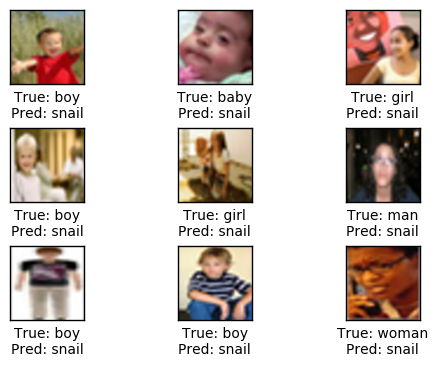

In [26]:
plot_images(X_test_five[:9], Y_test_class_five[:9], y_true_cls_pred_five[:9])

In [27]:
model_baby.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

score = model_baby.evaluate(X_test, Y_test, verbose=1)
print('\npretrained model without any finetuning, test on the whole cifar100 dataset')
print('Test accuracy: %.3f' % score[1])

 9952/10000 [============================>.] - ETA: 0s
pretrained model without any finetuning, test on the whole cofar100 dataset
Test accuracy: 0.010


In [78]:

from keras.optimizers import Adam, SGD
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# with decay, sometimes the model can't overfit the data
model_baby.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# VGG_model.compile(loss='categorical_crossentropy',
#               optimizer=adam,
#               metrics=['accuracy'])
# batch size 100, 128 不ok
batch_size = 256
nb_epoch = 80

%time small_mammals_his = model_baby.fit(X_train_small_mammals, Y_train_small_mammals, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          shuffle=True) \

# evaluate our model
score = model_baby.evaluate(X_test_people, Y_test_people, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
# test-acc = 0.65 in this setting now: 0.55

Train on 2000 samples, validate on 500 samples
Epoch 1/80
2000/2000 [==============================] - 5s - loss: 1.6096 - acc: 0.2075 - val_loss: 1.6095 - val_acc: 0.1820
Epoch 2/80
2000/2000 [==============================] - 1s - loss: 1.6092 - acc: 0.2055 - val_loss: 1.6091 - val_acc: 0.1820
Epoch 3/80
2000/2000 [==============================] - 1s - loss: 1.5947 - acc: 0.2035 - val_loss: 1.7339 - val_acc: 0.1820
Epoch 4/80
2000/2000 [==============================] - 1s - loss: 1.5895 - acc: 0.2060 - val_loss: 1.6399 - val_acc: 0.1820
Epoch 5/80
2000/2000 [==============================] - 1s - loss: 1.5719 - acc: 0.2070 - val_loss: 1.9504 - val_acc: 0.1820
Epoch 6/80
2000/2000 [==============================] - 1s - loss: 1.5113 - acc: 0.2005 - val_loss: 2.5367 - val_acc: 0.1960
Epoch 7/80


KeyboardInterrupt: 

In [123]:
# over-fitting here, X_train_easy
from keras.optimizers import Adam, SGD
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# with decay, sometimes the model can't overfit the data
model_baby.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# VGG_model.compile(loss='categorical_crossentropy',
#               optimizer=adam,
#               metrics=['accuracy'])
# batch size 100, 128 不ok
batch_size = 256
nb_epoch = 80

%time small_mammals_his = model_baby.fit(X_train_easy, Y_train_easy, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.1, \
          shuffle=True) \

# evaluate our model
score = model_baby.evaluate(X_test_easy, Y_test_easy, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
# test-acc = 0.65 in this setting now: 0.55

Train on 2250 samples, validate on 250 samples
Epoch 1/80
2250/2250 [==============================] - 8s - loss: 0.0306 - acc: 0.9920 - val_loss: 0.8685 - val_acc: 0.8120
Epoch 2/80
2250/2250 [==============================] - 1s - loss: 0.0593 - acc: 0.9884 - val_loss: 1.0879 - val_acc: 0.7760
Epoch 3/80
2250/2250 [==============================] - 1s - loss: 0.0311 - acc: 0.9920 - val_loss: 2.6398 - val_acc: 0.5400
Epoch 4/80
2250/2250 [==============================] - 1s - loss: 0.0191 - acc: 0.9938 - val_loss: 0.6265 - val_acc: 0.8680
Epoch 5/80
2250/2250 [==============================] - 1s - loss: 0.0235 - acc: 0.9924 - val_loss: 1.1535 - val_acc: 0.7880
Epoch 6/80
2250/2250 [==============================] - 1s - loss: 0.0154 - acc: 0.9969 - val_loss: 2.6872 - val_acc: 0.5360
Epoch 7/80
2250/2250 [==============================] - 1s - loss: 0.0161 - acc: 0.9951 - val_loss: 2.2871 - val_acc: 0.5920
Epoch 8/80
2250/2250 [==============================] - 1s - loss: 0.0076 - ac

In [42]:
########### plot validation history ############
def plot_validation_history(his, fig_path):
    train_loss = his.history['loss']
    val_loss = his.history['val_loss']

    # visualize training history
    plt.plot(range(1, len(train_loss)+1), train_loss, color='blue', label='Train loss')
    plt.plot(range(1, len(val_loss)+1), val_loss, color='red', label='Val loss')
    plt.legend(loc="upper right")
    plt.xlabel('#Epoch')
    plt.ylabel('Loss')
    plt.savefig(fig_path, dpi=300)
    plt.show()
# plot_validation_history(small_mammals_his, "baby_model_small_mammal_adam_with_decay")

NameError: name 'small_mammals_his' is not defined

In [34]:
X_train_people[0].shape

(32, 32, 3)

# try to fit the data using a more simple model

In [120]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time
from keras.datasets import cifar10
from keras.utils import np_utils
from matplotlib import pyplot as plt
from scipy.misc import toimage
# from keras import backend as K
import numpy as np
from keras.optimizers import Adam, SGD


# here are some settings for my network
# batchsize 128 doesn't work
batch_size = 256
nb_epoch = 50
# load data

img_chhannels = 3
img_size = 32
img_size = 32
nb_classes = 100

model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same',
                        input_shape=(img_size, img_size, img_channels)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

%time his = model.fit(X_train_easy, Y_train_easy, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.1, \
          shuffle=True) \

# evaluate our model
score = model.evaluate(X_test_easy, Y_test_easy, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.8) batch_size = 256 -> train 0.89, val -> 0
# validation_split = 0.1

Train on 2250 samples, validate on 250 samples
Epoch 1/50
2250/2250 [==============================] - 5s - loss: 12.9080 - acc: 0.1916 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/50
2250/2250 [==============================] - 0s - loss: 12.5363 - acc: 0.2222 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/50
2250/2250 [==============================] - 0s - loss: 12.5363 - acc: 0.2222 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/50
2250/2250 [==============================] - 0s - loss: 12.5363 - acc: 0.2222 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/50
2250/2250 [==============================] - 0s - loss: 12.5363 - acc: 0.2222 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 6/50
2250/2250 [==============================] - 0s - loss: 12.5363 - acc: 0.2222 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 7/50
2250/2250 [==============================] - 0s - loss: 12.5363 - acc: 0.2222 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 8/50
2250/2250 [==============

In [174]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time
from keras.datasets import cifar10
from keras.utils import np_utils
from matplotlib import pyplot as plt
from scipy.misc import toimage
# from keras import backend as K
import numpy as np
from keras.optimizers import Adam, SGD

# here are some settings for my network
# batchsize 128 doesn't work
batch_size = 512
nb_epoch = 50
# load data

img_chhannels = 3
img_size = 32
img_size = 32
nb_classes = 100

model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same',
                        input_shape=(img_size, img_size, img_channels)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(256))
# model.add(Dropout(0.25))
model.add(Dense(256))
# model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

%time his = model.fit(X_train_easy, Y_train_easy, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.1, \
          shuffle=True) \

# evaluate our model
score = model.evaluate(X_test_easy, Y_test_easy, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.8) batch_size = 256 -> train 0.89, val -> 0
# validation_split = 0.1
# conclusion: easy做得最好

Train on 2250 samples, validate on 250 samples
Epoch 1/50
2250/2250 [==============================] - 7s - loss: 3.6653 - acc: 0.1711 - val_loss: 2.2855 - val_acc: 0.0000e+00
Epoch 2/50
2250/2250 [==============================] - 0s - loss: 1.6481 - acc: 0.3809 - val_loss: 2.3860 - val_acc: 0.0000e+00
Epoch 3/50
2250/2250 [==============================] - 0s - loss: 1.3712 - acc: 0.4107 - val_loss: 2.1051 - val_acc: 0.0000e+00
Epoch 4/50
2250/2250 [==============================] - 0s - loss: 1.2200 - acc: 0.4982 - val_loss: 1.8531 - val_acc: 0.0000e+00
Epoch 5/50
2250/2250 [==============================] - 0s - loss: 1.0480 - acc: 0.5880 - val_loss: 1.5184 - val_acc: 0.0240
Epoch 6/50
2250/2250 [==============================] - 0s - loss: 0.9359 - acc: 0.6316 - val_loss: 1.8502 - val_acc: 0.0000e+00
Epoch 7/50
2250/2250 [==============================] - 0s - loss: 0.8076 - acc: 0.6809 - val_loss: 1.9762 - val_acc: 0.0000e+00
Epoch 8/50
2250/2250 [==============================] 

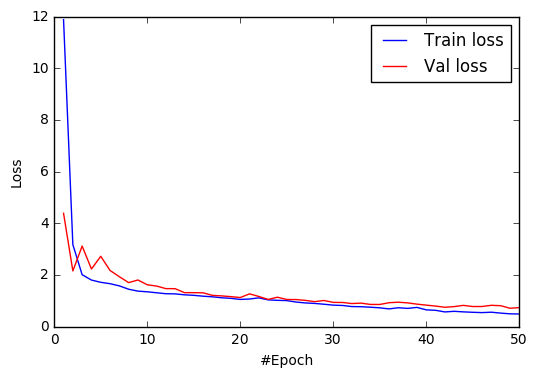

In [182]:
########### plot validation history ############
def plot_validation_history(his, fig_path):
    train_loss = his.history['loss']
    val_loss = his.history['val_loss']

    # visualize training history
    plt.plot(range(1, len(train_loss)+1), train_loss, color='blue', label='Train loss')
    plt.plot(range(1, len(val_loss)+1), val_loss, color='red', label='Val loss')
    plt.legend(loc="upper right")
    plt.xlabel('#Epoch')
    plt.ylabel('Loss')
    plt.savefig(fig_path, dpi=300)
    plt.show()
plot_validation_history(his, "baby_model_small_mammal_adam_with_decay")

In [181]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time
from keras.datasets import cifar10
from keras.utils import np_utils
from matplotlib import pyplot as plt
from scipy.misc import toimage
# from keras import backend as K
import numpy as np
from keras.optimizers import Adam, SGD


# here are some settings for my network
# batchsize 128 doesn't work
batch_size = 512
nb_epoch = 50
# load data

img_chhannels = 3
img_size = 32
img_size = 32
nb_classes = 100

model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same',
                        input_shape=(img_size, img_size, img_channels)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

%time his = model.fit(X_train_medium_sized_mammals, Y_train_medium_sized_mammals, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.1, \
          shuffle=True) \

# evaluate our model
score = model.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.8) batch_size = 256 -> train 0.89, val -> 0
# validation_split = 0.1

Train on 2250 samples, validate on 250 samples
Epoch 1/50
2250/2250 [==============================] - 8s - loss: 11.8785 - acc: 0.1698 - val_loss: 4.3823 - val_acc: 0.2400
Epoch 2/50
2250/2250 [==============================] - 0s - loss: 3.1697 - acc: 0.2062 - val_loss: 2.1511 - val_acc: 0.2200
Epoch 3/50
2250/2250 [==============================] - 0s - loss: 2.0042 - acc: 0.1987 - val_loss: 3.1137 - val_acc: 0.2360
Epoch 4/50
2250/2250 [==============================] - 0s - loss: 1.7974 - acc: 0.2093 - val_loss: 2.2253 - val_acc: 0.2440
Epoch 5/50
2250/2250 [==============================] - 0s - loss: 1.7107 - acc: 0.2169 - val_loss: 2.7176 - val_acc: 0.3200
Epoch 6/50
2250/2250 [==============================] - 0s - loss: 1.6572 - acc: 0.2409 - val_loss: 2.1684 - val_acc: 0.3640
Epoch 7/50
2250/2250 [==============================] - 0s - loss: 1.5723 - acc: 0.2787 - val_loss: 1.9279 - val_acc: 0.3880
Epoch 8/50
2250/2250 [==============================] - 0s - loss: 1.4427 - a

In [175]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time
from keras.datasets import cifar10
from keras.utils import np_utils
from matplotlib import pyplot as plt
from scipy.misc import toimage
# from keras import backend as K
import numpy as np
from keras.optimizers import Adam, SGD


# here are some settings for my network
# batchsize 128 doesn't work
batch_size = 512
nb_epoch = 50
# load data

img_chhannels = 3
img_size = 32
img_size = 32
nb_classes = 100

model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same',
                        input_shape=(img_size, img_size, img_channels)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(256))
# model.add(Dropout(0.25))
model.add(Dense(256))
# model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

%time his = model.fit(X_train_small_mammals, Y_train_small_mammals, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.1, \
          shuffle=True) \

# evaluate our model
score = model.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.8) batch_size = 256 -> train 0.89, val -> 0
# validation_split = 0.1

Train on 2250 samples, validate on 250 samples
Epoch 1/50
2250/2250 [==============================] - 7s - loss: 3.8204 - acc: 0.1418 - val_loss: 2.1051 - val_acc: 0.1920
Epoch 2/50
2250/2250 [==============================] - 0s - loss: 1.9090 - acc: 0.2244 - val_loss: 1.6694 - val_acc: 0.1920
Epoch 3/50
2250/2250 [==============================] - 0s - loss: 1.6305 - acc: 0.2431 - val_loss: 1.5792 - val_acc: 0.3240
Epoch 4/50
2250/2250 [==============================] - 0s - loss: 1.5445 - acc: 0.3036 - val_loss: 1.5059 - val_acc: 0.3480
Epoch 5/50
2250/2250 [==============================] - 0s - loss: 1.4800 - acc: 0.3538 - val_loss: 1.4876 - val_acc: 0.4240
Epoch 6/50
2250/2250 [==============================] - 0s - loss: 1.6014 - acc: 0.3200 - val_loss: 1.5971 - val_acc: 0.2520
Epoch 7/50
2250/2250 [==============================] - 0s - loss: 1.5333 - acc: 0.3156 - val_loss: 1.4762 - val_acc: 0.3960
Epoch 8/50
2250/2250 [==============================] - 0s - loss: 1.4199 - ac

In [183]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time
from keras.datasets import cifar10
from keras.utils import np_utils
from matplotlib import pyplot as plt
from scipy.misc import toimage
# from keras import backend as K
import numpy as np
from keras.optimizers import Adam, SGD


# here are some settings for my network
# batchsize 128 doesn't work
batch_size = 512
nb_epoch = 50
# load data

img_chhannels = 3
img_size = 32
img_size = 32
nb_classes = 100

model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same',
                        input_shape=(img_size, img_size, img_channels)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

%time his = model.fit(X_train_small_mammals, Y_train_small_mammals, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.1, \
          shuffle=True) \

# evaluate our model
score = model.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.8) batch_size = 256 -> train 0.89, val -> 0
# validation_split = 0.1

Train on 2250 samples, validate on 250 samples
Epoch 1/50
2250/2250 [==============================] - 8s - loss: 6.4185 - acc: 0.1378 - val_loss: 2.5306 - val_acc: 0.2600
Epoch 2/50
2250/2250 [==============================] - 0s - loss: 2.0252 - acc: 0.1791 - val_loss: 2.4422 - val_acc: 0.1800
Epoch 3/50
2250/2250 [==============================] - 0s - loss: 1.7918 - acc: 0.1916 - val_loss: 2.3093 - val_acc: 0.1920
Epoch 4/50
2250/2250 [==============================] - 0s - loss: 1.7061 - acc: 0.2031 - val_loss: 2.5917 - val_acc: 0.2160
Epoch 5/50
2250/2250 [==============================] - 0s - loss: 1.6665 - acc: 0.2258 - val_loss: 2.2088 - val_acc: 0.3040
Epoch 6/50
2250/2250 [==============================] - 0s - loss: 1.6259 - acc: 0.2342 - val_loss: 2.0317 - val_acc: 0.3200
Epoch 7/50
2250/2250 [==============================] - 0s - loss: 1.5613 - acc: 0.2951 - val_loss: 2.0679 - val_acc: 0.3200
Epoch 8/50
2250/2250 [==============================] - 0s - loss: 1.4996 - ac

In [178]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time
from keras.datasets import cifar10
from keras.utils import np_utils
from matplotlib import pyplot as plt
from scipy.misc import toimage
# from keras import backend as K
import numpy as np
from keras.optimizers import Adam, SGD


# here are some settings for my network
# batchsize 128 doesn't work
batch_size = 512
nb_epoch = 100
# load data

img_chhannels = 3
img_size = 32
img_size = 32
nb_classes = 100

model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same',
                        input_shape=(img_size, img_size, img_channels)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

%time his = model.fit(X_train_people, Y_train_people, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.1, \
          shuffle=True) \

# evaluate our model
score = model.evaluate(X_test_people, Y_test_people, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.8) batch_size = 256 -> train 0.89, val -> 0
# validation_split = 0.1

Train on 2250 samples, validate on 250 samples
Epoch 1/100
2250/2250 [==============================] - 8s - loss: 5.7057 - acc: 0.1142 - val_loss: 2.4621 - val_acc: 0.1760
Epoch 2/100
2250/2250 [==============================] - 0s - loss: 2.1227 - acc: 0.2009 - val_loss: 2.5097 - val_acc: 0.2160
Epoch 3/100
2250/2250 [==============================] - 0s - loss: 1.8761 - acc: 0.2227 - val_loss: 2.3451 - val_acc: 0.1920
Epoch 4/100
2250/2250 [==============================] - 0s - loss: 1.8241 - acc: 0.2004 - val_loss: 2.3053 - val_acc: 0.2360
Epoch 5/100
2250/2250 [==============================] - 0s - loss: 1.7756 - acc: 0.2076 - val_loss: 2.2286 - val_acc: 0.1920
Epoch 6/100
2250/2250 [==============================] - 0s - loss: 1.7465 - acc: 0.2164 - val_loss: 2.0658 - val_acc: 0.2200
Epoch 7/100
2250/2250 [==============================] - 0s - loss: 1.7104 - acc: 0.2289 - val_loss: 1.9769 - val_acc: 0.2320
Epoch 8/100
2250/2250 [==============================] - 0s - loss: 1.7

In [184]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time
from keras.datasets import cifar10
from keras.utils import np_utils
from matplotlib import pyplot as plt
from scipy.misc import toimage
# from keras import backend as K
import numpy as np
from keras.optimizers import Adam, SGD


# here are some settings for my network
# batchsize 128 doesn't work
batch_size = 512
nb_epoch = 100
# load data

img_chhannels = 3
img_size = 32
img_size = 32
nb_classes = 100

model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same',
                        input_shape=(img_size, img_size, img_channels)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

%time his = model.fit(X_train_fish, Y_train_fish, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.1, \
          shuffle=True) \

# evaluate our model
score = model.evaluate(X_test_fish, Y_test_fish, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.8) batch_size = 256 -> train 0.89, val -> 0
# validation_split = 0.1

Train on 2250 samples, validate on 250 samples
Epoch 1/100
2250/2250 [==============================] - 8s - loss: 6.9747 - acc: 0.1280 - val_loss: 2.4747 - val_acc: 0.2760
Epoch 2/100
2250/2250 [==============================] - 0s - loss: 2.0207 - acc: 0.2502 - val_loss: 2.0579 - val_acc: 0.4320
Epoch 3/100
2250/2250 [==============================] - 0s - loss: 1.6293 - acc: 0.3596 - val_loss: 1.7955 - val_acc: 0.3880
Epoch 4/100
2250/2250 [==============================] - 0s - loss: 1.5324 - acc: 0.3889 - val_loss: 1.6091 - val_acc: 0.4040
Epoch 5/100
2250/2250 [==============================] - 0s - loss: 1.4553 - acc: 0.3791 - val_loss: 1.7530 - val_acc: 0.5000
Epoch 6/100
2250/2250 [==============================] - 0s - loss: 1.3619 - acc: 0.4338 - val_loss: 1.4055 - val_acc: 0.5360
Epoch 7/100
2250/2250 [==============================] - 0s - loss: 1.2935 - acc: 0.4738 - val_loss: 1.5732 - val_acc: 0.5360
Epoch 8/100
2250/2250 [==============================] - 0s - loss: 1.2

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time
from keras.datasets import cifar10
from keras.utils import np_utils
from matplotlib import pyplot as plt
from scipy.misc import toimage
# from keras import backend as K
import numpy as np
from keras.optimizers import Adam, SGD


# here are some settings for my network
# batchsize 128 doesn't work
batch_size = 512
nb_epoch = 100
# load data

img_chhannels = 3
img_size = 32
img_size = 32
nb_classes = 100

model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same',
                        input_shape=(img_size, img_size, img_channels)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

%time his = model.fit(X_train_fish, Y_train_fish, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.1, \
          shuffle=True) \

# evaluate our model
score = model.evaluate(X_test_fish, Y_test_fish, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.8) batch_size = 256 -> train 0.89, val -> 0
# validation_split = 0.1

In [172]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time
from keras.datasets import cifar10
from keras.utils import np_utils
from matplotlib import pyplot as plt
from scipy.misc import toimage
# from keras import backend as K
import numpy as np
from keras.optimizers import Adam, SGD


# here are some settings for my network
# batchsize 128 doesn't work
batch_size = 512
nb_epoch = 50
# load data

img_chhannels = 3
img_size = 32
img_size = 32
nb_classes = 100

model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same',
                        input_shape=(img_size, img_size, img_channels)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.99)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

%time his = model.fit(X_train, Y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.1, \
          shuffle=True) \

# evaluate our model
score = model.evaluate(X_test, Y_test, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.8) batch_size = 256 -> train 0.89, val -> 0
# validation_split = 0.1

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 16s - loss: 4.5502 - acc: 0.0268 - val_loss: 4.2715 - val_acc: 0.0538
Epoch 2/50
45000/45000 [==============================] - 9s - loss: 4.0770 - acc: 0.0674 - val_loss: 4.0522 - val_acc: 0.0970
Epoch 3/50
45000/45000 [==============================] - 9s - loss: 3.8119 - acc: 0.1080 - val_loss: 3.8928 - val_acc: 0.1142
Epoch 4/50
45000/45000 [==============================] - 9s - loss: 3.5905 - acc: 0.1454 - val_loss: 3.5579 - val_acc: 0.1708
Epoch 5/50
45000/45000 [==============================] - 9s - loss: 3.3953 - acc: 0.1779 - val_loss: 3.4953 - val_acc: 0.1766
Epoch 6/50
45000/45000 [==============================] - 9s - loss: 3.2390 - acc: 0.2060 - val_loss: 3.3916 - val_acc: 0.1874
Epoch 7/50
45000/45000 [==============================] - 9s - loss: 3.0817 - acc: 0.2346 - val_loss: 3.2254 - val_acc: 0.2230
Epoch 8/50
45000/45000 [==============================] - 9s 

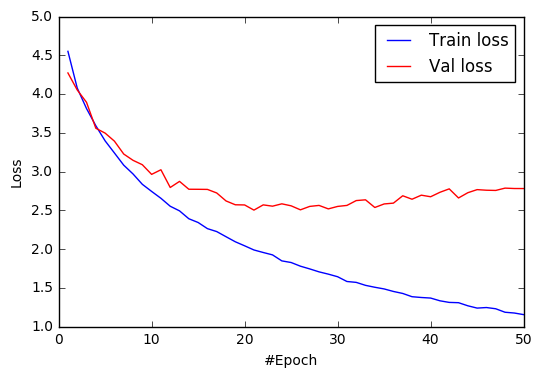

In [173]:
########### plot validation history ############
def plot_validation_history(his, fig_path):
    train_loss = his.history['loss']
    val_loss = his.history['val_loss']

    # visualize training history
    plt.plot(range(1, len(train_loss)+1), train_loss, color='blue', label='Train loss')
    plt.plot(range(1, len(val_loss)+1), val_loss, color='red', label='Val loss')
    plt.legend(loc="upper right")
    plt.xlabel('#Epoch')
    plt.ylabel('Loss')
    plt.savefig(fig_path, dpi=300)
    plt.show()
plot_validation_history(his, "baby_model_small_mammal_adam_with_decay")

In [44]:
# sample_images(X_test_people)
# sample_images(X_test_small_mammals)
# sample_images(X_test_medium_sized_mammals)
# sample_images(X_test_aquatic_mammals)
# sample_images(X_test_fish)
score = model_baby.evaluate(X_test_people, Y_test_people, verbose=1)
print('\npeople')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nsmall mammals')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nmedium mammal')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1)
print('\naquatic')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_fish, Y_test_fish, verbose=1)
print('\nfish')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

500/500 [==============================] - 0s     

people

Test loss: 14.895
Test accuracy: 0.000
352/500 [====================>.........] - ETA: 0s
small mammals

Test loss: 1.512
Test accuracy: 0.474
352/500 [====================>.........] - ETA: 0s
medium mammal

Test loss: 15.144
Test accuracy: 0.000
352/500 [====================>.........] - ETA: 0s
aquatic

Test loss: 14.809
Test accuracy: 0.000
352/500 [====================>.........] - ETA: 0s
fish

Test loss: 14.674
Test accuracy: 0.000


@TODO this is weird....

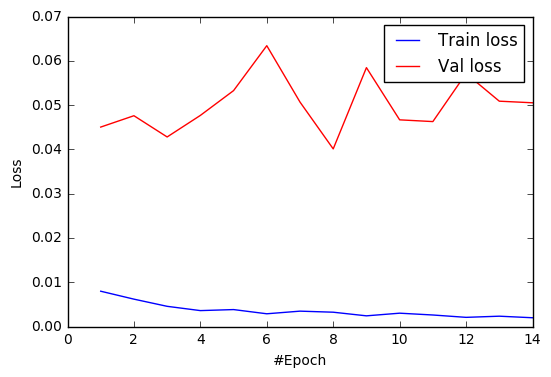

In [134]:
########### plot validation history ############
def plot_validation_history(his, fig_path):
    train_loss = his.history['loss']
    val_loss = his.history['val_loss']

    # visualize training history
    plt.plot(range(1, len(train_loss)+1), train_loss, color='blue', label='Train loss')
    plt.plot(range(1, len(val_loss)+1), val_loss, color='red', label='Val loss')
    plt.legend(loc="upper right")
    plt.xlabel('#Epoch')
    plt.ylabel('Loss')
    plt.savefig(fig_path, dpi=300)
    plt.show()
import lib
plot_validation_history(his, "baby_model_people_sgd")

In [45]:
batch_size = 32
nb_epoch = 30

%time his_small_mammals = model_baby.fit(X_train_people, Y_train_people, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          verbose=True, \
          shuffle=True) \
# 有一直learn到零的問題，取消call back

# evaluate our model
score = model_baby.evaluate(X_test_people, Y_test_people, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
# score = model_baby.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
# print('\nTest loss: %.3f' % score[0])
# print('Test accuracy: %.3f' % score[1])
# print(model_baby.predict(X_test_medium_sized_mammals, batch_size=32, verbose=1))


Train on 2000 samples, validate on 500 samples
Epoch 1/30
2000/2000 [==============================] - 2s - loss: 2.4091 - acc: 0.1720 - val_loss: 1.6095 - val_acc: 0.1900
Epoch 2/30
2000/2000 [==============================] - 2s - loss: 1.6095 - acc: 0.1930 - val_loss: 1.6095 - val_acc: 0.2040
Epoch 3/30
2000/2000 [==============================] - 2s - loss: 1.6095 - acc: 0.2105 - val_loss: 1.6095 - val_acc: 0.1940
Epoch 4/30
2000/2000 [==============================] - 2s - loss: 1.6095 - acc: 0.2105 - val_loss: 1.6095 - val_acc: 0.1920
Epoch 5/30
2000/2000 [==============================] - 2s - loss: 1.6095 - acc: 0.1905 - val_loss: 1.6095 - val_acc: 0.1940
Epoch 6/30
2000/2000 [==============================] - 2s - loss: 1.6095 - acc: 0.2005 - val_loss: 1.6095 - val_acc: 0.1940
Epoch 7/30
2000/2000 [==============================] - 2s - loss: 1.6095 - acc: 0.1850 - val_loss: 1.6095 - val_acc: 0.1980
Epoch 8/30
2000/2000 [==============================] - 2s - loss: 1.6095 - ac

In [46]:
score = model_baby.evaluate(X_test_people, Y_test_people, verbose=1)
print('\npeople')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nsmall mammals')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nmedium mammal')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1)
print('\naquatic')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_fish, Y_test_fish, verbose=1)
print('\nfish')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

500/500 [==============================] - 0s     

people

Test loss: 1.609
Test accuracy: 0.206
500/500 [==============================] - 0s     

small mammals

Test loss: 13.664
Test accuracy: 0.000
352/500 [====================>.........] - ETA: 0s
medium mammal

Test loss: 16.118
Test accuracy: 0.000
352/500 [====================>.........] - ETA: 0s
aquatic

Test loss: 16.118
Test accuracy: 0.000
352/500 [====================>.........] - ETA: 0s
fish

Test loss: 16.118
Test accuracy: 0.000


In [25]:
def random_init_image(img_width, img_height):
    # we start from a gray image with some random noise
    if K.image_dim_ordering() == 'th':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    return input_img_data

# dimensions of the generated pictures for each filter.
img_width, img_height = X_train[0].shape[1], X_train[0].shape[2]


# Step 1: Random initialize noise image
input_img_data = random_init_image(img_width, img_height)
check_(input_img_data)
plt.figure()
plt.imshow(toimage(input_img_data[0]))

layer_tensor = model_baby.layer_tensors[2]
layer_tensor

layer_tensor = model_baby.layer_tensors[6]
X_distorted = []

for index, img in enumerate(X_train_people[:2]):
    img_result = optimize_image(layer_tensor, input_img_data,
                                num_iterations=10, step_size=6.0, tile_size=400,
                                show_gradient=False)
    # save_image(img_result, filename='deep_dream_cifar10/deepdream_cifar10_'+str(index)+'__without_tile,jpg')
    X_distorted.append(img_result)
    print(index+4000)
    import pickle
    if (index+1) % 500 == 0:
        print("save 500")
        with open('dreamed_image_4000_'+str(index+4000)+'.p', 'wb') as f:
            pickle.dump(X_distorted, f) 
            
            

NameError: name 'check_' is not defined

In [38]:
import tensorflow as tf
y_pred = model_baby.predict(X_test_medium_sized_mammals, batch_size=32, verbose=1)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, Y_test_class_medium_sized_mammals)


500/500 [==============================] - 0s     


In [47]:
%time his_medium_sized_mammals = model_baby.fit(X_train_medium_sized_mammals, Y_train_medium_sized_mammals, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          verbose=False, \
          shuffle=True) \

# evaluate our model
score = model_baby.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

CPU times: user 42.2 s, sys: 4.52 s, total: 46.7 s
Wall time: 46.4 s
352/500 [====================>.........] - ETA: 0s
Test loss: 1.609
Test accuracy: 0.200
352/500 [====================>.........] - ETA: 0s
Test loss: 16.118
Test accuracy: 0.000


In [48]:
score = model_baby.evaluate(X_test_people, Y_test_people, verbose=1)
print('\npeople')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_small_mammals, Y_test_small_mammals, verbose=1)
print('\nsmall mammals')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_medium_sized_mammals, Y_test_medium_sized_mammals, verbose=1)
print('\nmedium mammal')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1)
print('\naquatic')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_test_fish, Y_test_fish, verbose=1)
print('\nfish')
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

500/500 [==============================] - 0s     

people

Test loss: 16.118
Test accuracy: 0.000
500/500 [==============================] - 0s     

small mammals

Test loss: 14.357
Test accuracy: 0.000
352/500 [====================>.........] - ETA: 0s
medium mammal

Test loss: 1.609
Test accuracy: 0.200
352/500 [====================>.........] - ETA: 0s
aquatic

Test loss: 16.118
Test accuracy: 0.000
352/500 [====================>.........] - ETA: 0s
fish

Test loss: 16.118
Test accuracy: 0.000


In [138]:
%time his_aquatic_mammals = model_baby.fit(X_train_aquatic_mammals, Y_train_aquatic_mammals, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          verbose=False, \
          shuffle=True) \

# evaluate our model
score = model_baby.evaluate(X_test_aquatic_mammals, Y_test_aquatic_mammals, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
score = model_baby.evaluate(X_train_fish, Y_train_fish, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

CPU times: user 35.9 s, sys: 9.07 s, total: 45 s
Wall time: 45 s
480/500 [===========================>..] - ETA: 0s
Test loss: 0.028
Test accuracy: 0.988
2496/2500 [============================>.] - ETA: 0s
Test loss: 0.169
Test accuracy: 0.982


In [139]:
%time his_aquatic_mammals = model_baby.fit(X_train_fish, Y_train_fish, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_split=0.2, \
          callbacks=[early_stop], \
          verbose=False, \
          shuffle=True) \


# evaluate our model
score = model_baby.evaluate(X_train_fish, Y_train_fish, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

CPU times: user 45.6 s, sys: 11.7 s, total: 57.3 s
Wall time: 57.3 s
2496/2500 [============================>.] - ETA: 0s
Test loss: 0.022
Test accuracy: 0.991


In [61]:
# evaluate our model with all data of the five coarse category
score = model_baby.evaluate(X_test_five, Y_test_five, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

2496/2500 [============================>.] - ETA: 0s
Test loss: 0.086
Test accuracy: 0.983


In [ ]:
# evaluate our model with all data of the five coarse category
score = model_baby.evaluate(X_test, Y_test, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

In [66]:
# evaluate our model with all data of the five coarse category
score = model_baby.evaluate(X_test, Y_test, verbose=1)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

 9984/10000 [============================>.] - ETA: 0s
Test loss: 0.131
Test accuracy: 0.982


### Show Some Predictions

Note that the images look a little weird because their mean RGB values have been subtracted away.